In [11]:
import numpy as np
import scipy.io
from scipy import stats
from copy import copy
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize as spo
from sklearn.linear_model import ElasticNet
import numpy.linalg as npl
import numpy.random as npr
from scipy.stats.mstats import linregress
from sklearn.decomposition import PCA
root2over = 1/np.sqrt(2)
erf_max = sp.special.erf(root2over)

#function to standardize the MEG data matrices, which have very small values around e-13, e-14
def standardize(data_matrix):
    #create a copy of the data_matrix and make it normalized_sensor_matrix, will just replace values in row during loop
    x = data_matrix[:]
    x-=np.mean(x) # the -= means can be read as x = x- np.mean(x)
    x/=np.std(x) # the /= means can be read as x = x/np.std(x)
    return x

# helper function to store all the sensor labels across patients present in the total dataset
def store_labels(sensor_labels, patient):
    all_sensor_labels = []
    for i in range(sensor_labels.shape[0]):
        new_tag = sensor_labels[i][0][0]+"_"+patient
        all_sensor_labels.append(new_tag)
    return all_sensor_labels

def store_reg_labels(sensor_labels, patient):
    all_sensor_labels = []
    for i in range(sensor_labels.shape[0]):
        new_tag = sensor_labels[i][0][0]
        all_sensor_labels.append(new_tag)
    return all_sensor_labels

#function to load the MEG data from an array with all the patient ids. Returns the raw and normalized MEG data
def load_sensor_matrix(id_list):
    labels_dict = {}
    separated_dataset = {}
    first_iteration = True   #boolean value that accomodates the first run through of MEG data
    for patient in id_list:
        data = scipy.io.loadmat('HCP_dataset/'+patient+'/MEG/Restin/rmegpreproc/'+patient+'_MEG_3-Restin_rmegpreproc.mat')
        data_times = data['data'][0][0][5][:]    #extracts the timecourses of the MEG data
        data_labels = data['data'][0][0][6][:]  #extracts the sensor labels for the MEG data
        data_trials = data['data'][0][0][4][:]   #extracts the MEG potentials over the given timecourse
        separated_dataset[patient] = data_trials[0][0]
        if first_iteration:
            sensor_matrix = data_trials[0][0][:]
            first_iteration = False    #no longer in the first iteration of the loop, set to false
        else:
            #if not in the first run through, append the matrices together, to form a combined matrix
            sensor_matrix = np.concatenate((sensor_matrix, data_trials[0][0][:]), axis = 0)
        #create an array with all the sensor_labels for every patient in the dataset
        all_data_labels = store_labels(data_labels, patient)
        labels_dict[patient] = set(store_reg_labels(data_labels, patient))
    return sensor_matrix, separated_dataset, all_data_labels, labels_dict

def common_labels(labels_dict):
    s = set()
    labels_dict_values = list(labels_dict.values())
    for index in range(len(labels_dict_values)-1):
        if bool(s) == False:
            s = set(labels_dict_values[index]).intersection(labels_dict_values[index+1])
        else:
            s = s.intersection(set(labels_dict_values[index+1]))
    return s

def form_dataset(common_labels_set, separated_dataset, labels_dict):
    streamlined_dataset = {}
    for patient in separated_dataset:
        for label in common_labels_set:
            channel_number = list(labels_dict[patient]).index(label)
            if patient not in streamlined_dataset:
                streamlined_dataset[patient] = [separated_dataset[patient][channel_number, :]]
            else:
                streamlined_dataset[patient].append(separated_dataset[patient][channel_number, :])
    return streamlined_dataset

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize as spo
from sklearn.linear_model import ElasticNet
import numpy.linalg as npl
import numpy.random as npr
root2over = 1/np.sqrt(2)

def simulate(size,time_steps,w = 0.0,sigma = 1.0,coupling = 1.0,rho = 0.2):
    if npl.norm(w)==0.:
        sigma = (npr.rand(1,size)+1)/2.0
        w = npr.rand(size,size) - 0.5
    #     w = w.dot(w.T)
        w = coupling*w - rho*np.eye(size)
    x = np.zeros((time_steps,size))
    x_min = np.zeros((1,size))
    x[0] = npr.rand(1,size)-0.5
    #x[0] = initial
    for i in range(time_steps-1):
        x[i+1] = (1)*x[i] + np.tanh(x[i].dot(w)) + sigma*npr.normal(size=(1,size))
#         x[i+1] = np.maximum(x_min,(1-rho)*x[i] + rho*np.sqrt(np.maximum(x_min,x[i].dot(w)))) \
#                             + np.exp(sigma*npr.normal(size=(1,size)))
    return x-np.mean(x,axis=0)[np.newaxis,:],w,sigma

def find_sigma(y,h):
    time_steps,size = y.shape
    sigma = np.std(y-h,axis=0)
#     sigma = np.random.rand(1,size) + 0.5
#     for index in range(size):
#         def f0(sig):
#             return (1-np.std(y[:,index]/np.abs(sig) - h[:,index]))**2
#         res = spo.minimize(f0,sigma[0,index])
#         sigma[0,index] = np.abs(res.x)
    return(sigma.reshape(1,size))

def time_shift_cov(x,shift=1):
    time_steps,size = x.shape
    x0 = (x - np.mean(x,axis=0))/np.std(x,axis=0)
    return x0[shift:].T.dot(x0[:-shift])/np.float(time_steps-shift)

def enet_solve(c,b):
    regr = ElasticNet(random_state=0,max_iter=10000)
    regr.fit(c,b)
    return regr.coef_

def moving_avg(a,window):
    cu = np.cumsum(a,axis=0,dtype=float)
    cu[window:] = cu[window:] - cu[:-window]
    return cu[window-1:]/window

def infer(x,max_iter = 100,tol=1e-8,func=npl.solve,window=1):
    time_steps,size = x.shape    
    x0 = x[:] - np.mean(x[:],axis=0)
    if window>1:
        x0 = moving_avg(x0,window)
        time_steps = time_steps-window+1
    y = np.diff(x0,axis=0)
    y -= np.mean(y,axis=0)
    x0 = x0[:-1]
    print(x0.shape, y.shape)
    s = np.sign(y)
    c = np.cov(x,rowvar=False)
    w = npr.rand(size,size) - 0.5
    h = np.tanh(x0.dot(w))
    for index in range(size):
        err_old,error = 0,np.inf
        #         print(index)
        while np.abs(error-err_old) > tol:
            zeros = np.abs(x0.dot(w[:,index])) < 1e-12
            ratio = np.sqrt(np.pi/2.0)*np.ones((time_steps-1))
            ratio[~zeros] = (x0[~zeros,:].dot(w))[:,index]/sp.special.erf(h[~zeros,index]*root2over)
            #             w[:,index] = func(c+0.1*np.eye(size),np.mean(x0*(s[:,index]*ratio)[:,np.newaxis],axis=0))
            w[:,index] = func(c,np.mean(x0*(s[:,index]*ratio)[:,np.newaxis],axis=0))

#             w[:,index] = func(c+0.1*np.eye(size),np.mean(x0*((s[:,index]/np.erf(h[:,index]*root2over))*x0.dot(w)[:,index])[:,np.newaxis],axis=0))
            err_old = error
            h[:,index] = np.tanh(x0.dot(w[:,index]))
            error = npl.norm(s[:,index]-sp.special.erf(h[:,index]*root2over))
    sigma = find_sigma(y,h)*np.sqrt(window)
    return w*sigma[0][None,:],sigma


def pca_combine_datasets(streamlined_dataset):
    pca_combined_dataset = np.array([])
    for patient in streamlined_dataset:
        x = np.asarray(streamlined_dataset[patient])
        if pca_combined_dataset.size == 0:
            pca_combined_dataset = x
        else:
            pca_combined_dataset = np.concatenate((pca_combined_dataset, x), axis=1 )
    return pca_combined_dataset

def calculate_allW(dataset, given_power):
    allwmatrices = {}
    allsigs = {}
    allbiases = {}
    for patient in dataset:
        w, sig = infer(dataset[patient].transpose())
        allwmatrices[patient] = w
        allsigs[patient] = sig
    return allwmatrices, allsigs

def calculate_allTimeCov(dataset, time_shift):
    alltimeshiftcov = {}
    for patient in dataset:
        timeshiftcovmatrix = time_shift_cov(dataset[patient].transpose(), shift=time_shift)
        alltimeshiftcov[patient] = timeshiftcovmatrix
    return alltimeshiftcov

def hcp_inference(dataset_ids, pca_components, time_shift, power):
    print("Running Newest Inference Linear with Power Fixed:")
    print("1. PCA components =", pca_components)
    print("2. Time shifts =", time_shift)
    print("3. Power =", power)
    sensor_matrix, separated_dataset, all_data_labels, labels_dict = load_sensor_matrix(dataset_ids)
    common_labels_set = common_labels(labels_dict.copy())
    streamlined_dataset = form_dataset(common_labels_set.copy(), separated_dataset.copy(), labels_dict.copy())
    normalized_streamlined_dataset = {}
    for patient in streamlined_dataset:
        normalized_streamlined_dataset[patient] = standardize(streamlined_dataset[patient])
    pca_data_dict = {}
    pca_combined_dataset = pca_combine_datasets(normalized_streamlined_dataset.copy())
    pca = PCA(n_components=pca_components)
    pca.fit(pca_combined_dataset.T)
    transformed_data = pca.fit_transform(pca_combined_dataset.T)
    counter = 0
    for patient in normalized_streamlined_dataset:
        pca_data_dict[patient] = transformed_data[counter*1018:1018*(counter+1), :].T
        counter = counter + 1
    allwmatrices, allsigs = calculate_allW(pca_data_dict, power)
    alltscmatrices = calculate_allTimeCov(pca_data_dict, time_shift)
    return allwmatrices, alltscmatrices, allsigs, pca_data_dict

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.mstats import linregress
%matplotlib inline

In [3]:
power = 1
pca_components = 10
time_shift = 10
dataset_ids = ['100307', '102816', '105923', '106521', '108323', '109123', '111514', '112920', 
               '116524', '116726', '133019', '140117', '146129', '149741', '153732', '154532', 
               '156334', '158136', '162026', '162935', '164636', '166438', '169040', '172029', 
               '174841', '175237', '175540', '177746', '179245', '181232', '185442', '187547', 
               '189349', '191033', '191437', '191841', '192641', '195041', '198653', '204521', 
               '205119', '212318', '212823', '214524', '221319', '223929', '233326', '248339', 
               '250427', '255639', '257845', '283543', '287248', '293748', '352132', '352738', 
               '353740', '358144', '406836', '433839', '512835', '555348', '559053', '568963', 
               '581450', '599671', '601127', '660951', '662551', '665254', '667056', '679770', 
               '680957', '706040', '707749', '715950', '725751', '735148', '783462', '814649',
               '825048', '872764', '877168', '891667', '898176', '912447', '917255', '990366']

In [18]:
allwmatrices, alltscmatrices, allsigs, pca_data_dict = hcp_inference(dataset_ids, pca_components, time_shift, power)

Running Newest Inference Linear with Power Fixed:
1. PCA components = 10
2. Time shifts = 10
3. Power = 1
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (1017, 10)
(1017, 10) (10

In [ ]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
pvalue_linear_10trials = []
counter = 0
pvalue_bytimeshift = []
timeshifts = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for timeshift in timeshifts:
    for i in range(20):
        pvalue_linear_array = []
        for patient in allwmatrices:
            w = allwmatrices[patient]
            sig = allsigs[patient]
            bias = allbiases[patient]

            x_original = pca_data_dict[patient].T.copy()

            # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
            simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, initial=x_original[0])

            # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
            tsc_original = time_shift_cov(x_original, shift=timeshift)
            tsc_simulated = time_shift_cov(simulated_data[0], shift=timeshift)


            line_object = linregress(tsc_original, tsc_simulated)
    #         plt.title('Patient ' + str(patient))
    #         plt.xlabel('time_shift_cov original')
    #         plt.ylabel('time_shift_cov simulated')
    #         plt.plot(tsc_original, tsc_simulated, 'ko', alpha=0.5)
    #         plt.plot([-1, 1], [-1,1], 'r--')
    #         time_shift_axes = np.arange(-1, 2)
    #         plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
    #         plt.show()
    #         print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
    #         print("--------------------------------------------------------------")
            pvalue_nonlinear_average += line_object.pvalue
            pvalue_linear_array.append(line_object.pvalue)
            slope_average += line_object.slope
            counter += 1
        pvalue_linear_10trials.append(np.mean(pvalue_linear_array))
    print('mean', np.mean(pvalue_linear_10trials))
    print('std', np.std(pvalue_linear_10trials))
    pvalue_bytimeshift.append(np.mean(pvalue_linear_10trials))
print(pvalue_bytimeshift)

[ 2.52504482 -1.98582059 -0.56329517 -0.38340557 -0.72354908  1.29748383
  0.03230429  0.58718213  0.01492713 -1.72427413]
[-1.03850871 -4.05020673 -0.01610168  1.16983818  3.71883331  0.12105242
 -2.81285954 -1.95460333  0.01270754 -0.11611293]
[-2.85272213  3.48237957 -1.18854091 -1.31162913  0.23706666 -1.37252361
 -0.53778099  0.01818822 -0.50129675 -1.26870189]
[ 1.67280612  0.06432064  4.90628095  2.42727098 -4.69629391  0.77215781
  1.67431494  1.1729651  -0.84898554  2.81614987]
[-1.72696134  0.69011195 -1.37892208 -1.64321916 -1.25138328 -1.50716995
 -0.28710213  0.153677    0.46264805  0.39150439]
[-0.37290735  0.7405174  -0.77156476 -0.96637463 -1.49942327  0.34989491
 -0.27031822 -0.9449338  -0.80030791 -1.09452656]
[ 7.79794144 -2.9888014   2.87130721 -0.70092288  0.38361537 -1.80721462
  3.90844779  2.12845091  2.43922757  0.58675943]
[ 9.46395215 -3.85184265  2.33406479 -3.27396753  1.18427452 -4.03637808
  1.6822232  -1.15369397 -1.88309641 -2.14928365]
[ 2.91362847  1.

[ 1.50200726  0.46850716 -2.62691906 -1.99130743  0.73615383 -2.54996904
  0.2974154   1.02743296 -0.11434084 -0.19020745]
[-0.51857131  1.36603581  1.16846834 -1.40342205  2.81960531 -0.55781214
  0.69390227  1.98118499 -1.14864318  0.26938743]
[ 5.82350343  0.22950033 -0.28470177  0.59827213  1.82668851  2.10103319
 -0.42732319 -0.0249995   2.29989607  0.8633978 ]
[-0.25922883 -0.02566209  0.27569688 -1.58058267 -2.0284173  -1.36041624
 -0.66518076  1.23510946 -0.61298436  0.58223206]
[ 1.23628903 -2.07339301  1.73887534  0.461161    0.60910164 -1.84845964
  1.82248581 -2.74562658  0.33295951 -0.00687597]
[-1.99608645  3.2297693  -2.69131813  4.2439511  -1.1907765   1.82473328
 -2.53525899  1.32484219 -2.07193328  2.53479525]
[ 2.53073003  1.47976374 -0.12185826 -0.08278253 -0.1460547  -2.57191679
 -1.9443694   0.35399469  0.44227919 -0.50347481]
[ 0.32849054  0.58108894 -1.24380242  1.13322569 -2.01172644 -0.58164017
  0.6190129  -1.39679013 -0.62590831 -0.43474591]
[-0.18547344  6.

[-2.52813839  0.11194577  0.7882582  -5.90282189  2.04762154 -1.34429092
  0.39309059  0.22542083  1.95527263 -0.76948864]
[ 0.20497165 -4.1115069  -1.76752634 -1.24344057 -0.72545246 -2.46867416
  1.62759591 -0.73833495  0.22866182  0.33324939]
[ 2.5805402  -2.40495828  0.04281962 -0.70673905 -2.7505166   0.33673867
  3.42480159 -1.25375325 -1.00673236 -0.60362589]
[-2.33956854 -2.46501509  1.89203894 -0.63035794  1.74098041  0.69103379
  1.12486494 -0.77177668  0.13225007 -1.22792456]
[ 1.61816167  4.38210505  0.53809957  4.66034808 -0.50334644 -0.20922943
  0.87042778  0.96763483 -1.26320475 -0.120163  ]
[ 2.50956891  1.0243567   2.00516524 -2.10870589  0.32133668 -0.51332202
  1.96169767 -0.57680461 -1.80357702  0.2902138 ]
[-1.4528705  -0.22536306 -1.57026862 -4.1809988  -1.85657522  2.21523688
  0.9018555   1.37866269 -0.66094369  0.60577471]
[-2.99382632  0.80240531 -1.38823533 -3.24928058 -0.34910701 -0.80143374
  1.08003628  0.5826884   0.75359425  0.49407651]
[-4.60196019 -2.

[-1.66801045  4.88976459  3.47220978  1.71994344 -0.36515033  0.81879537
  0.82607911  2.13644453 -2.60958742  0.32027887]
[ 0.46929242 -3.33505343  2.73819602  1.61697446 -0.38563077  0.3051168
  1.02277581 -0.14928639  1.79517429  2.06112314]
[-3.2737437   1.38470655 -3.38078996  5.54203158 -1.19477604 -1.27903296
  1.22843852  3.31223161  1.64454524  0.75854994]
[ 0.30703454 -0.82856417  1.54236011  0.358758   -4.05303919  0.91234813
 -1.30647818 -0.21355802 -1.18986993  0.42312905]
[ 1.11576518  0.33639167  2.40043871 -2.82937177  1.99714583 -1.21833214
  0.67539062  0.21315922 -1.40288898  0.27673167]
[ 1.26317458  0.23212621 -0.84285819 -0.03267878  2.13653148  0.55222023
  2.97912605  0.47675709  0.03631451 -0.13896667]
[ 0.84575414  7.34372956 -0.76389281 -0.79984202 -1.07334312  2.17886638
 -1.50759268 -0.11627599 -1.16917095  0.79808188]
[-9.9644886   3.88662467  1.11411759  1.93067669 -0.84255033 -1.50581314
 -0.48784432 -2.19119036 -2.03662507 -1.63004616]
[-2.9039437  -1.3

[ 0.70667956 -2.23078336 -4.81592522 -0.51687882 -3.31111694 -0.33255568
  0.77016457  1.61522538 -1.26180025  0.89992337]
[-0.27598865 -0.38160876  0.42126496  1.07920518 -1.51230681  2.50938134
 -0.71140898  0.65172066 -0.15280646  0.45534434]
[ 0.08280783 -0.44323184  1.01517863  1.9950639   0.81827728 -0.647801
  0.01483121 -1.16426266  1.48298348  1.60133636]
[-0.6021767  -2.20644106 -2.63323806 -0.04263041  0.30076261 -0.27758996
  1.4263983   0.76141796 -0.32982769 -1.18520701]
[-1.64725991 -1.0252473  -7.18990211 -0.90181308  5.54610816  2.11089696
  1.18127028 -0.81822944 -1.24826428  1.9682622 ]
[-1.75766476  0.28743563  0.82168267  1.72052407 -3.34287905 -1.02178413
  0.49624453 -1.53623266  0.90643188 -1.18250154]
[ 1.15975025 -1.62831551 -2.21331029 -1.158416   -2.16844883 -0.03857561
 -0.90197943 -0.38582719  0.55674885  1.21461945]
[ 3.63530919 -5.7697691   2.06124899  1.15066381  3.44384332  0.64227447
  0.21473698  2.44644794 -0.10251516 -0.55233842]
[ 3.64752357 -0.32

[-0.2776008  -0.34112676 -1.73970921 -1.17631797 -1.03064845  0.17105143
  0.09653261 -0.31447635 -0.41689916  0.05092801]
[ 2.52504482 -1.98582059 -0.56329517 -0.38340557 -0.72354908  1.29748383
  0.03230429  0.58718213  0.01492713 -1.72427413]
[-1.03850871 -4.05020673 -0.01610168  1.16983818  3.71883331  0.12105242
 -2.81285954 -1.95460333  0.01270754 -0.11611293]
[-2.85272213  3.48237957 -1.18854091 -1.31162913  0.23706666 -1.37252361
 -0.53778099  0.01818822 -0.50129675 -1.26870189]
[ 1.67280612  0.06432064  4.90628095  2.42727098 -4.69629391  0.77215781
  1.67431494  1.1729651  -0.84898554  2.81614987]
[-1.72696134  0.69011195 -1.37892208 -1.64321916 -1.25138328 -1.50716995
 -0.28710213  0.153677    0.46264805  0.39150439]
[-0.37290735  0.7405174  -0.77156476 -0.96637463 -1.49942327  0.34989491
 -0.27031822 -0.9449338  -0.80030791 -1.09452656]
[ 7.79794144 -2.9888014   2.87130721 -0.70092288  0.38361537 -1.80721462
  3.90844779  2.12845091  2.43922757  0.58675943]
[ 9.46395215 -3.

[ 0.00607079 -1.83377103 -0.34284895  0.1508523  -0.01739483  1.1551855
 -0.51610032 -1.25852942 -0.00504213 -0.68259818]
[ 3.01114938  0.59945731 -0.01210492 -0.93576965 -1.33316629 -2.26669501
  0.00389619  1.21363545 -0.52529981  0.08549263]
[ 3.23980223  4.36425359 -3.76371103 -4.83615625  2.36120837 -1.8711212
  2.77366284  0.19191649 -0.89474829  0.97642633]
[ 4.19873174  2.42743363 -0.73266097  2.09662181 -0.15248771  1.13356488
 -1.8613111  -1.82591738 -1.14131263  1.79020792]
[-3.27112549  2.68024426 -5.34308618 -0.44182672  0.12265999 -1.23892034
 -2.73378282 -0.22525666 -2.02176321 -0.85566884]
[-0.8041056  -0.60376457  4.46274194 -0.54209704 -1.59593442  2.55118609
  1.37089322  0.00473066  0.40754651  2.33497475]
[ 2.7107921  -2.50699856 -3.72224825  1.4680555   0.71339541 -2.90084968
  0.80094486 -0.41261149  0.78382791 -1.92880694]
[ 1.50200726  0.46850716 -2.62691906 -1.99130743  0.73615383 -2.54996904
  0.2974154   1.02743296 -0.11434084 -0.19020745]
[-0.51857131  1.36

[ 1.86077241  0.85278848  0.03428403 -1.61182652 -0.06723355 -0.05524316
 -0.39705473 -0.88629959 -0.21032296  0.19086843]
[-1.64102721  5.39060013 -0.37916769  0.93263715  1.50972004 -1.26913019
  0.96547957 -2.46031416  0.74087831 -1.52365506]
[-1.51416096e+00 -2.56522194e+00  1.07435487e-03 -4.33063181e-01
 -1.17472234e+00 -6.01898679e-01  7.01227120e-01  2.70805741e-01
  3.38612608e-01 -6.89021064e-01]
[-7.60719697 -7.40325338  1.42164406  0.7152064  -1.06652759  0.41461545
 -1.84920272  0.24818919  2.53925503 -1.28771457]
[-5.96560301  3.37570047 -3.80057455  1.92663367  2.46133464 -2.90765614
 -0.57035237  0.83590351  1.96996518  3.09294209]
[-0.51757239 -0.48925581  1.58527635 -0.32494679  0.41508801 -0.85911626
  0.28861467  0.47195971 -0.22978221 -0.55734974]
[-2.7487932  -3.41791482 -0.41879388  1.06998012  2.8863349   0.30234929
 -0.6804819  -0.27628094  1.52320973 -0.07477007]
[-2.52813839  0.11194577  0.7882582  -5.90282189  2.04762154 -1.34429092
  0.39309059  0.22542083 

[ 2.41111434 -5.20159106 -1.26274555 -1.45321623 -0.5301551   0.22593882
 -0.10267835 -1.30490289  0.27160955 -1.37534357]
[ 8.95212129 -0.25811504  1.05685365 -0.8404385   1.8075736  -1.06723161
 -1.89562123  0.38107273 -2.29348882 -0.18059027]
[ 4.34393074  0.73339563  0.9687903  -1.68676826 -1.09033471 -0.72784257
  0.64348782  1.51860554  1.14234598 -0.9145399 ]
[ 0.15276841 -2.0091485  -2.04845067  0.5293476   4.43575905  0.12717593
  0.59319205  0.94647528 -0.98025598  0.33545836]
[ 5.97935044 -1.36308904 -1.1777705  -0.60020215  0.44284625  0.85253679
  0.38498474  2.89002578 -1.17800948 -1.09279567]
[-5.38504565 -7.33479988 -4.07590546 -2.69857034  0.30416589  1.33725846
  2.51008487  0.51612282  0.81264391 -1.09788586]
[-1.79637989  0.33086921  1.06645934 -0.47158543 -0.41051564 -1.99756121
 -1.61138316  0.92259686  1.35758994  0.97478746]
[ 0.0105875   2.92941218 -0.1890903   0.4497783  -2.95430601 -0.40720726
 -2.26815967 -0.18194342 -0.22913393  1.15871757]
[-1.76035723 -3.

[ 9.46395215 -3.85184265  2.33406479 -3.27396753  1.18427452 -4.03637808
  1.6822232  -1.15369397 -1.88309641 -2.14928365]
[ 2.91362847  1.63606388  1.01159522 -1.28585438 -1.18973605  1.67246168
 -0.33993258 -1.85004135  2.39357136 -0.61145787]
[ 0.20388787  3.64324122 -4.37444026  1.61662402  0.35399341 -3.2512125
  4.51213017  2.93659841 -2.43548452 -1.55685221]
[ 0.34374983  1.14967495 -1.63984174  2.04474094  1.03619576  1.42916017
 -0.73303627 -0.28243637  0.01351241  0.26098941]
[ 1.43979696  2.76774165 -0.10904455 -0.62762828 -1.06636406 -0.9114521
 -0.9731551  -0.23215614 -0.08553765 -0.45724997]
[ 1.45656291  1.05391444  1.2246993  -0.83198067 -0.35074138 -0.77064891
  0.3207285   0.18127409  0.03237451  1.08390905]
[ 5.75854762 -4.02910916  2.07565373 -1.59855529 -0.41332649 -0.21721196
 -1.2935811  -0.00817137 -2.56995407 -0.31865882]
[-5.21681428  0.41208474 -1.56887634  0.93344373  0.40536782 -0.98543139
  1.51418746  1.29754675  2.61352393 -0.01310667]
[ 0.70667956 -2.23

[ 2.53073003  1.47976374 -0.12185826 -0.08278253 -0.1460547  -2.57191679
 -1.9443694   0.35399469  0.44227919 -0.50347481]
[ 0.32849054  0.58108894 -1.24380242  1.13322569 -2.01172644 -0.58164017
  0.6190129  -1.39679013 -0.62590831 -0.43474591]
[-0.18547344  6.19288377 -0.56748894  0.39485595 -6.55227232  0.08585686
 -1.38635549  1.1673517   1.78351343 -0.30474785]
[ 3.61389304  6.44161799  3.62204448  1.34017117 -2.7298587  -0.31152415
  0.1857286   0.44274406 -0.23126837 -1.12323417]
[-0.08006304 -1.98542339 -0.29846491 -0.60308933 -2.09230301 -1.62757724
 -0.81693531  1.00313502  0.91847377 -1.91982551]
[ 6.82407211 -2.52347294 -1.80495914  0.79494264  0.86995903 -0.22591599
  2.17446805  0.04853577 -0.07786318  0.13146562]
[-0.72115035  1.61792515 -0.32172953  0.03179006  2.19437981 -0.34668184
 -0.83963766 -0.75262943  0.7004452  -0.25757183]
[-2.28175308  1.3104171  -1.36704393  1.04212649  1.39396892  1.22278763
  0.28019417 -0.80752319  0.81364651  2.23295593]
[-0.2776008  -0.

[-1.4528705  -0.22536306 -1.57026862 -4.1809988  -1.85657522  2.21523688
  0.9018555   1.37866269 -0.66094369  0.60577471]
[-2.99382632  0.80240531 -1.38823533 -3.24928058 -0.34910701 -0.80143374
  1.08003628  0.5826884   0.75359425  0.49407651]
[-4.60196019 -2.16462173  1.96879215  1.23491879  0.56322972  0.88387282
 -1.65740447 -0.15209764  0.95212827 -0.46728304]
[ 1.32035407  4.24447135  2.03576906 -1.70625303 -0.12134238 -1.23853816
 -0.18937892 -0.80886824  2.22434565 -1.34590039]
[ 2.88207241  2.52838389  2.03080803  1.38163467 -2.69763871  0.17392911
  0.57606372  0.18479943 -1.40205157  1.32981068]
[ 1.82837213 -5.50341923  3.72438809 -2.82355186 -1.54020139  2.48909391
  1.89375096  0.88713643  1.44615249 -1.13630736]
[ 7.6829414  -0.14110178 -2.43138678  7.7027474  -2.2386115  -1.05033794
  2.05533319  3.05267896  1.22792409 -1.48768787]
[ 2.26865821  1.82938247  0.39461242 -1.52489902  0.61391102 -0.46943184
 -0.77182402 -0.3248779   0.9650859  -0.69721143]
[ 0.00607079 -1.

[ 0.46929242 -3.33505343  2.73819602  1.61697446 -0.38563077  0.3051168
  1.02277581 -0.14928639  1.79517429  2.06112314]
[-3.2737437   1.38470655 -3.38078996  5.54203158 -1.19477604 -1.27903296
  1.22843852  3.31223161  1.64454524  0.75854994]
[ 0.30703454 -0.82856417  1.54236011  0.358758   -4.05303919  0.91234813
 -1.30647818 -0.21355802 -1.18986993  0.42312905]
[ 1.11576518  0.33639167  2.40043871 -2.82937177  1.99714583 -1.21833214
  0.67539062  0.21315922 -1.40288898  0.27673167]
[ 1.26317458  0.23212621 -0.84285819 -0.03267878  2.13653148  0.55222023
  2.97912605  0.47675709  0.03631451 -0.13896667]
[ 0.84575414  7.34372956 -0.76389281 -0.79984202 -1.07334312  2.17886638
 -1.50759268 -0.11627599 -1.16917095  0.79808188]
[-9.9644886   3.88662467  1.11411759  1.93067669 -0.84255033 -1.50581314
 -0.48784432 -2.19119036 -2.03662507 -1.63004616]
[-2.9039437  -1.36277525  1.97004836  1.36504162 -0.98476064  2.79070068
 -1.29389874 -1.85429654  0.8230843   0.94531771]
[ 1.86077241  0.8

[-0.6021767  -2.20644106 -2.63323806 -0.04263041  0.30076261 -0.27758996
  1.4263983   0.76141796 -0.32982769 -1.18520701]
[-1.64725991 -1.0252473  -7.18990211 -0.90181308  5.54610816  2.11089696
  1.18127028 -0.81822944 -1.24826428  1.9682622 ]
[-1.75766476  0.28743563  0.82168267  1.72052407 -3.34287905 -1.02178413
  0.49624453 -1.53623266  0.90643188 -1.18250154]
[ 1.15975025 -1.62831551 -2.21331029 -1.158416   -2.16844883 -0.03857561
 -0.90197943 -0.38582719  0.55674885  1.21461945]
[ 3.63530919 -5.7697691   2.06124899  1.15066381  3.44384332  0.64227447
  0.21473698  2.44644794 -0.10251516 -0.55233842]
[ 3.64752357 -0.32337889 -0.65269045  0.55564142  0.71508742  1.58734626
  0.1797723  -0.5398597   0.94487138 -1.01062044]
[ 2.41111434 -5.20159106 -1.26274555 -1.45321623 -0.5301551   0.22593882
 -0.10267835 -1.30490289  0.27160955 -1.37534357]
[ 8.95212129 -0.25811504  1.05685365 -0.8404385   1.8075736  -1.06723161
 -1.89562123  0.38107273 -2.29348882 -0.18059027]
[ 4.34393074  0.

[-0.72115035  1.61792515 -0.32172953  0.03179006  2.19437981 -0.34668184
 -0.83963766 -0.75262943  0.7004452  -0.25757183]
[-2.28175308  1.3104171  -1.36704393  1.04212649  1.39396892  1.22278763
  0.28019417 -0.80752319  0.81364651  2.23295593]
[-0.2776008  -0.34112676 -1.73970921 -1.17631797 -1.03064845  0.17105143
  0.09653261 -0.31447635 -0.41689916  0.05092801]
[ 2.52504482 -1.98582059 -0.56329517 -0.38340557 -0.72354908  1.29748383
  0.03230429  0.58718213  0.01492713 -1.72427413]
[-1.03850871 -4.05020673 -0.01610168  1.16983818  3.71883331  0.12105242
 -2.81285954 -1.95460333  0.01270754 -0.11611293]
[-2.85272213  3.48237957 -1.18854091 -1.31162913  0.23706666 -1.37252361
 -0.53778099  0.01818822 -0.50129675 -1.26870189]
[ 1.67280612  0.06432064  4.90628095  2.42727098 -4.69629391  0.77215781
  1.67431494  1.1729651  -0.84898554  2.81614987]
[-1.72696134  0.69011195 -1.37892208 -1.64321916 -1.25138328 -1.50716995
 -0.28710213  0.153677    0.46264805  0.39150439]
[-0.37290735  0.

[ 7.6829414  -0.14110178 -2.43138678  7.7027474  -2.2386115  -1.05033794
  2.05533319  3.05267896  1.22792409 -1.48768787]
[ 2.26865821  1.82938247  0.39461242 -1.52489902  0.61391102 -0.46943184
 -0.77182402 -0.3248779   0.9650859  -0.69721143]
[ 0.00607079 -1.83377103 -0.34284895  0.1508523  -0.01739483  1.1551855
 -0.51610032 -1.25852942 -0.00504213 -0.68259818]
[ 3.01114938  0.59945731 -0.01210492 -0.93576965 -1.33316629 -2.26669501
  0.00389619  1.21363545 -0.52529981  0.08549263]
[ 3.23980223  4.36425359 -3.76371103 -4.83615625  2.36120837 -1.8711212
  2.77366284  0.19191649 -0.89474829  0.97642633]
[ 4.19873174  2.42743363 -0.73266097  2.09662181 -0.15248771  1.13356488
 -1.8613111  -1.82591738 -1.14131263  1.79020792]
[-3.27112549  2.68024426 -5.34308618 -0.44182672  0.12265999 -1.23892034
 -2.73378282 -0.22525666 -2.02176321 -0.85566884]
[-0.8041056  -0.60376457  4.46274194 -0.54209704 -1.59593442  2.55118609
  1.37089322  0.00473066  0.40754651  2.33497475]
[ 2.7107921  -2.50

[-7.60719697 -7.40325338  1.42164406  0.7152064  -1.06652759  0.41461545
 -1.84920272  0.24818919  2.53925503 -1.28771457]
[-5.96560301  3.37570047 -3.80057455  1.92663367  2.46133464 -2.90765614
 -0.57035237  0.83590351  1.96996518  3.09294209]
[-0.51757239 -0.48925581  1.58527635 -0.32494679  0.41508801 -0.85911626
  0.28861467  0.47195971 -0.22978221 -0.55734974]
[-2.7487932  -3.41791482 -0.41879388  1.06998012  2.8863349   0.30234929
 -0.6804819  -0.27628094  1.52320973 -0.07477007]
[-2.52813839  0.11194577  0.7882582  -5.90282189  2.04762154 -1.34429092
  0.39309059  0.22542083  1.95527263 -0.76948864]
[ 0.20497165 -4.1115069  -1.76752634 -1.24344057 -0.72545246 -2.46867416
  1.62759591 -0.73833495  0.22866182  0.33324939]
[ 2.5805402  -2.40495828  0.04281962 -0.70673905 -2.7505166   0.33673867
  3.42480159 -1.25375325 -1.00673236 -0.60362589]
[-2.33956854 -2.46501509  1.89203894 -0.63035794  1.74098041  0.69103379
  1.12486494 -0.77177668  0.13225007 -1.22792456]
[ 1.61816167  4.

[ 0.15276841 -2.0091485  -2.04845067  0.5293476   4.43575905  0.12717593
  0.59319205  0.94647528 -0.98025598  0.33545836]
[ 5.97935044 -1.36308904 -1.1777705  -0.60020215  0.44284625  0.85253679
  0.38498474  2.89002578 -1.17800948 -1.09279567]
[-5.38504565 -7.33479988 -4.07590546 -2.69857034  0.30416589  1.33725846
  2.51008487  0.51612282  0.81264391 -1.09788586]
[-1.79637989  0.33086921  1.06645934 -0.47158543 -0.41051564 -1.99756121
 -1.61138316  0.92259686  1.35758994  0.97478746]
[ 0.0105875   2.92941218 -0.1890903   0.4497783  -2.95430601 -0.40720726
 -2.26815967 -0.18194342 -0.22913393  1.15871757]
[-1.76035723 -3.03060567  0.43833706  0.4844844  -2.61226058  1.31507748
 -1.95252862  2.22695343  0.69154117 -2.25868441]
[ 5.54341124 -5.71057364 -1.38469301 -0.99481135 -2.4698568   0.68981469
 -1.43442005  0.80218732  1.80711152  1.17137642]
[-1.02612053 -4.01508268 -7.63602725 -1.02748387  1.77034111 -0.45352475
  0.35643064  0.2570731   0.56524213  0.48244372]
[-0.59851567 -5.

[ 9.46395215 -3.85184265  2.33406479 -3.27396753  1.18427452 -4.03637808
  1.6822232  -1.15369397 -1.88309641 -2.14928365]
[ 2.91362847  1.63606388  1.01159522 -1.28585438 -1.18973605  1.67246168
 -0.33993258 -1.85004135  2.39357136 -0.61145787]
[ 0.20388787  3.64324122 -4.37444026  1.61662402  0.35399341 -3.2512125
  4.51213017  2.93659841 -2.43548452 -1.55685221]
[ 0.34374983  1.14967495 -1.63984174  2.04474094  1.03619576  1.42916017
 -0.73303627 -0.28243637  0.01351241  0.26098941]
[ 1.43979696  2.76774165 -0.10904455 -0.62762828 -1.06636406 -0.9114521
 -0.9731551  -0.23215614 -0.08553765 -0.45724997]
[ 1.45656291  1.05391444  1.2246993  -0.83198067 -0.35074138 -0.77064891
  0.3207285   0.18127409  0.03237451  1.08390905]
[ 5.75854762 -4.02910916  2.07565373 -1.59855529 -0.41332649 -0.21721196
 -1.2935811  -0.00817137 -2.56995407 -0.31865882]
[-5.21681428  0.41208474 -1.56887634  0.93344373  0.40536782 -0.98543139
  1.51418746  1.29754675  2.61352393 -0.01310667]
[ 0.70667956 -2.23

[-0.51857131  1.36603581  1.16846834 -1.40342205  2.81960531 -0.55781214
  0.69390227  1.98118499 -1.14864318  0.26938743]
[ 5.82350343  0.22950033 -0.28470177  0.59827213  1.82668851  2.10103319
 -0.42732319 -0.0249995   2.29989607  0.8633978 ]
[-0.25922883 -0.02566209  0.27569688 -1.58058267 -2.0284173  -1.36041624
 -0.66518076  1.23510946 -0.61298436  0.58223206]
[ 1.23628903 -2.07339301  1.73887534  0.461161    0.60910164 -1.84845964
  1.82248581 -2.74562658  0.33295951 -0.00687597]
[-1.99608645  3.2297693  -2.69131813  4.2439511  -1.1907765   1.82473328
 -2.53525899  1.32484219 -2.07193328  2.53479525]
[ 2.53073003  1.47976374 -0.12185826 -0.08278253 -0.1460547  -2.57191679
 -1.9443694   0.35399469  0.44227919 -0.50347481]
[ 0.32849054  0.58108894 -1.24380242  1.13322569 -2.01172644 -0.58164017
  0.6190129  -1.39679013 -0.62590831 -0.43474591]
[-0.18547344  6.19288377 -0.56748894  0.39485595 -6.55227232  0.08585686
 -1.38635549  1.1673517   1.78351343 -0.30474785]
[ 3.61389304  6.

[ 0.20497165 -4.1115069  -1.76752634 -1.24344057 -0.72545246 -2.46867416
  1.62759591 -0.73833495  0.22866182  0.33324939]
[ 2.5805402  -2.40495828  0.04281962 -0.70673905 -2.7505166   0.33673867
  3.42480159 -1.25375325 -1.00673236 -0.60362589]
[-2.33956854 -2.46501509  1.89203894 -0.63035794  1.74098041  0.69103379
  1.12486494 -0.77177668  0.13225007 -1.22792456]
[ 1.61816167  4.38210505  0.53809957  4.66034808 -0.50334644 -0.20922943
  0.87042778  0.96763483 -1.26320475 -0.120163  ]
[ 2.50956891  1.0243567   2.00516524 -2.10870589  0.32133668 -0.51332202
  1.96169767 -0.57680461 -1.80357702  0.2902138 ]
[-1.4528705  -0.22536306 -1.57026862 -4.1809988  -1.85657522  2.21523688
  0.9018555   1.37866269 -0.66094369  0.60577471]
[-2.99382632  0.80240531 -1.38823533 -3.24928058 -0.34910701 -0.80143374
  1.08003628  0.5826884   0.75359425  0.49407651]
[-4.60196019 -2.16462173  1.96879215  1.23491879  0.56322972  0.88387282
 -1.65740447 -0.15209764  0.95212827 -0.46728304]
[ 1.32035407  4.

[-1.76035723 -3.03060567  0.43833706  0.4844844  -2.61226058  1.31507748
 -1.95252862  2.22695343  0.69154117 -2.25868441]
[ 5.54341124 -5.71057364 -1.38469301 -0.99481135 -2.4698568   0.68981469
 -1.43442005  0.80218732  1.80711152  1.17137642]
[-1.02612053 -4.01508268 -7.63602725 -1.02748387  1.77034111 -0.45352475
  0.35643064  0.2570731   0.56524213  0.48244372]
[-0.59851567 -5.00921001 -1.34828271 -2.36837658  3.19990865  3.23019583
  2.46896484 -1.49320847 -0.60605096 -0.0822067 ]
[-1.66801045  4.88976459  3.47220978  1.71994344 -0.36515033  0.81879537
  0.82607911  2.13644453 -2.60958742  0.32027887]
[ 0.46929242 -3.33505343  2.73819602  1.61697446 -0.38563077  0.3051168
  1.02277581 -0.14928639  1.79517429  2.06112314]
[-3.2737437   1.38470655 -3.38078996  5.54203158 -1.19477604 -1.27903296
  1.22843852  3.31223161  1.64454524  0.75854994]
[ 0.30703454 -0.82856417  1.54236011  0.358758   -4.05303919  0.91234813
 -1.30647818 -0.21355802 -1.18986993  0.42312905]
[ 1.11576518  0.3

[ 0.08280783 -0.44323184  1.01517863  1.9950639   0.81827728 -0.647801
  0.01483121 -1.16426266  1.48298348  1.60133636]
[-0.6021767  -2.20644106 -2.63323806 -0.04263041  0.30076261 -0.27758996
  1.4263983   0.76141796 -0.32982769 -1.18520701]
[-1.64725991 -1.0252473  -7.18990211 -0.90181308  5.54610816  2.11089696
  1.18127028 -0.81822944 -1.24826428  1.9682622 ]
[-1.75766476  0.28743563  0.82168267  1.72052407 -3.34287905 -1.02178413
  0.49624453 -1.53623266  0.90643188 -1.18250154]
[ 1.15975025 -1.62831551 -2.21331029 -1.158416   -2.16844883 -0.03857561
 -0.90197943 -0.38582719  0.55674885  1.21461945]
[ 3.63530919 -5.7697691   2.06124899  1.15066381  3.44384332  0.64227447
  0.21473698  2.44644794 -0.10251516 -0.55233842]
[ 3.64752357 -0.32337889 -0.65269045  0.55564142  0.71508742  1.58734626
  0.1797723  -0.5398597   0.94487138 -1.01062044]
[ 2.41111434 -5.20159106 -1.26274555 -1.45321623 -0.5301551   0.22593882
 -0.10267835 -1.30490289  0.27160955 -1.37534357]
[ 8.95212129 -0.25

[-2.85272213  3.48237957 -1.18854091 -1.31162913  0.23706666 -1.37252361
 -0.53778099  0.01818822 -0.50129675 -1.26870189]
[ 1.67280612  0.06432064  4.90628095  2.42727098 -4.69629391  0.77215781
  1.67431494  1.1729651  -0.84898554  2.81614987]
[-1.72696134  0.69011195 -1.37892208 -1.64321916 -1.25138328 -1.50716995
 -0.28710213  0.153677    0.46264805  0.39150439]
[-0.37290735  0.7405174  -0.77156476 -0.96637463 -1.49942327  0.34989491
 -0.27031822 -0.9449338  -0.80030791 -1.09452656]
[ 7.79794144 -2.9888014   2.87130721 -0.70092288  0.38361537 -1.80721462
  3.90844779  2.12845091  2.43922757  0.58675943]
[ 9.46395215 -3.85184265  2.33406479 -3.27396753  1.18427452 -4.03637808
  1.6822232  -1.15369397 -1.88309641 -2.14928365]
[ 2.91362847  1.63606388  1.01159522 -1.28585438 -1.18973605  1.67246168
 -0.33993258 -1.85004135  2.39357136 -0.61145787]
[ 0.20388787  3.64324122 -4.37444026  1.61662402  0.35399341 -3.2512125
  4.51213017  2.93659841 -2.43548452 -1.55685221]
[ 0.34374983  1.1

[-3.27112549  2.68024426 -5.34308618 -0.44182672  0.12265999 -1.23892034
 -2.73378282 -0.22525666 -2.02176321 -0.85566884]
[-0.8041056  -0.60376457  4.46274194 -0.54209704 -1.59593442  2.55118609
  1.37089322  0.00473066  0.40754651  2.33497475]
[ 2.7107921  -2.50699856 -3.72224825  1.4680555   0.71339541 -2.90084968
  0.80094486 -0.41261149  0.78382791 -1.92880694]
[ 1.50200726  0.46850716 -2.62691906 -1.99130743  0.73615383 -2.54996904
  0.2974154   1.02743296 -0.11434084 -0.19020745]
[-0.51857131  1.36603581  1.16846834 -1.40342205  2.81960531 -0.55781214
  0.69390227  1.98118499 -1.14864318  0.26938743]
[ 5.82350343  0.22950033 -0.28470177  0.59827213  1.82668851  2.10103319
 -0.42732319 -0.0249995   2.29989607  0.8633978 ]
[-0.25922883 -0.02566209  0.27569688 -1.58058267 -2.0284173  -1.36041624
 -0.66518076  1.23510946 -0.61298436  0.58223206]
[ 1.23628903 -2.07339301  1.73887534  0.461161    0.60910164 -1.84845964
  1.82248581 -2.74562658  0.33295951 -0.00687597]
[-1.99608645  3.

[-5.96560301  3.37570047 -3.80057455  1.92663367  2.46133464 -2.90765614
 -0.57035237  0.83590351  1.96996518  3.09294209]
[-0.51757239 -0.48925581  1.58527635 -0.32494679  0.41508801 -0.85911626
  0.28861467  0.47195971 -0.22978221 -0.55734974]
[-2.7487932  -3.41791482 -0.41879388  1.06998012  2.8863349   0.30234929
 -0.6804819  -0.27628094  1.52320973 -0.07477007]
[-2.52813839  0.11194577  0.7882582  -5.90282189  2.04762154 -1.34429092
  0.39309059  0.22542083  1.95527263 -0.76948864]
[ 0.20497165 -4.1115069  -1.76752634 -1.24344057 -0.72545246 -2.46867416
  1.62759591 -0.73833495  0.22866182  0.33324939]
[ 2.5805402  -2.40495828  0.04281962 -0.70673905 -2.7505166   0.33673867
  3.42480159 -1.25375325 -1.00673236 -0.60362589]
[-2.33956854 -2.46501509  1.89203894 -0.63035794  1.74098041  0.69103379
  1.12486494 -0.77177668  0.13225007 -1.22792456]
[ 1.61816167  4.38210505  0.53809957  4.66034808 -0.50334644 -0.20922943
  0.87042778  0.96763483 -1.26320475 -0.120163  ]
[ 2.50956891  1.

[ 5.54341124 -5.71057364 -1.38469301 -0.99481135 -2.4698568   0.68981469
 -1.43442005  0.80218732  1.80711152  1.17137642]
[-1.02612053 -4.01508268 -7.63602725 -1.02748387  1.77034111 -0.45352475
  0.35643064  0.2570731   0.56524213  0.48244372]
[-0.59851567 -5.00921001 -1.34828271 -2.36837658  3.19990865  3.23019583
  2.46896484 -1.49320847 -0.60605096 -0.0822067 ]
[-1.66801045  4.88976459  3.47220978  1.71994344 -0.36515033  0.81879537
  0.82607911  2.13644453 -2.60958742  0.32027887]
[ 0.46929242 -3.33505343  2.73819602  1.61697446 -0.38563077  0.3051168
  1.02277581 -0.14928639  1.79517429  2.06112314]
[-3.2737437   1.38470655 -3.38078996  5.54203158 -1.19477604 -1.27903296
  1.22843852  3.31223161  1.64454524  0.75854994]
[ 0.30703454 -0.82856417  1.54236011  0.358758   -4.05303919  0.91234813
 -1.30647818 -0.21355802 -1.18986993  0.42312905]
[ 1.11576518  0.33639167  2.40043871 -2.82937177  1.99714583 -1.21833214
  0.67539062  0.21315922 -1.40288898  0.27673167]
[ 1.26317458  0.2

[ 1.45656291  1.05391444  1.2246993  -0.83198067 -0.35074138 -0.77064891
  0.3207285   0.18127409  0.03237451  1.08390905]
[ 5.75854762 -4.02910916  2.07565373 -1.59855529 -0.41332649 -0.21721196
 -1.2935811  -0.00817137 -2.56995407 -0.31865882]
[-5.21681428  0.41208474 -1.56887634  0.93344373  0.40536782 -0.98543139
  1.51418746  1.29754675  2.61352393 -0.01310667]
[ 0.70667956 -2.23078336 -4.81592522 -0.51687882 -3.31111694 -0.33255568
  0.77016457  1.61522538 -1.26180025  0.89992337]
[-0.27598865 -0.38160876  0.42126496  1.07920518 -1.51230681  2.50938134
 -0.71140898  0.65172066 -0.15280646  0.45534434]
[ 0.08280783 -0.44323184  1.01517863  1.9950639   0.81827728 -0.647801
  0.01483121 -1.16426266  1.48298348  1.60133636]
[-0.6021767  -2.20644106 -2.63323806 -0.04263041  0.30076261 -0.27758996
  1.4263983   0.76141796 -0.32982769 -1.18520701]
[-1.64725991 -1.0252473  -7.18990211 -0.90181308  5.54610816  2.11089696
  1.18127028 -0.81822944 -1.24826428  1.9682622 ]
[-1.75766476  0.28

[ 0.32849054  0.58108894 -1.24380242  1.13322569 -2.01172644 -0.58164017
  0.6190129  -1.39679013 -0.62590831 -0.43474591]
[-0.18547344  6.19288377 -0.56748894  0.39485595 -6.55227232  0.08585686
 -1.38635549  1.1673517   1.78351343 -0.30474785]
[ 3.61389304  6.44161799  3.62204448  1.34017117 -2.7298587  -0.31152415
  0.1857286   0.44274406 -0.23126837 -1.12323417]
[-0.08006304 -1.98542339 -0.29846491 -0.60308933 -2.09230301 -1.62757724
 -0.81693531  1.00313502  0.91847377 -1.91982551]
[ 6.82407211 -2.52347294 -1.80495914  0.79494264  0.86995903 -0.22591599
  2.17446805  0.04853577 -0.07786318  0.13146562]
[-0.72115035  1.61792515 -0.32172953  0.03179006  2.19437981 -0.34668184
 -0.83963766 -0.75262943  0.7004452  -0.25757183]
[-2.28175308  1.3104171  -1.36704393  1.04212649  1.39396892  1.22278763
  0.28019417 -0.80752319  0.81364651  2.23295593]
[-0.2776008  -0.34112676 -1.73970921 -1.17631797 -1.03064845  0.17105143
  0.09653261 -0.31447635 -0.41689916  0.05092801]
[ 2.52504482 -1.

[-4.60196019 -2.16462173  1.96879215  1.23491879  0.56322972  0.88387282
 -1.65740447 -0.15209764  0.95212827 -0.46728304]
[ 1.32035407  4.24447135  2.03576906 -1.70625303 -0.12134238 -1.23853816
 -0.18937892 -0.80886824  2.22434565 -1.34590039]
[ 2.88207241  2.52838389  2.03080803  1.38163467 -2.69763871  0.17392911
  0.57606372  0.18479943 -1.40205157  1.32981068]
[ 1.82837213 -5.50341923  3.72438809 -2.82355186 -1.54020139  2.48909391
  1.89375096  0.88713643  1.44615249 -1.13630736]
[ 7.6829414  -0.14110178 -2.43138678  7.7027474  -2.2386115  -1.05033794
  2.05533319  3.05267896  1.22792409 -1.48768787]
[ 2.26865821  1.82938247  0.39461242 -1.52489902  0.61391102 -0.46943184
 -0.77182402 -0.3248779   0.9650859  -0.69721143]
[ 0.00607079 -1.83377103 -0.34284895  0.1508523  -0.01739483  1.1551855
 -0.51610032 -1.25852942 -0.00504213 -0.68259818]
[ 3.01114938  0.59945731 -0.01210492 -0.93576965 -1.33316629 -2.26669501
  0.00389619  1.21363545 -0.52529981  0.08549263]
[ 3.23980223  4.3

[-2.9039437  -1.36277525  1.97004836  1.36504162 -0.98476064  2.79070068
 -1.29389874 -1.85429654  0.8230843   0.94531771]
[ 1.86077241  0.85278848  0.03428403 -1.61182652 -0.06723355 -0.05524316
 -0.39705473 -0.88629959 -0.21032296  0.19086843]
[-1.64102721  5.39060013 -0.37916769  0.93263715  1.50972004 -1.26913019
  0.96547957 -2.46031416  0.74087831 -1.52365506]
[-1.51416096e+00 -2.56522194e+00  1.07435487e-03 -4.33063181e-01
 -1.17472234e+00 -6.01898679e-01  7.01227120e-01  2.70805741e-01
  3.38612608e-01 -6.89021064e-01]
[-7.60719697 -7.40325338  1.42164406  0.7152064  -1.06652759  0.41461545
 -1.84920272  0.24818919  2.53925503 -1.28771457]
[-5.96560301  3.37570047 -3.80057455  1.92663367  2.46133464 -2.90765614
 -0.57035237  0.83590351  1.96996518  3.09294209]
[-0.51757239 -0.48925581  1.58527635 -0.32494679  0.41508801 -0.85911626
  0.28861467  0.47195971 -0.22978221 -0.55734974]
[-2.7487932  -3.41791482 -0.41879388  1.06998012  2.8863349   0.30234929
 -0.6804819  -0.27628094 

[-5.38504565 -7.33479988 -4.07590546 -2.69857034  0.30416589  1.33725846
  2.51008487  0.51612282  0.81264391 -1.09788586]
[-1.79637989  0.33086921  1.06645934 -0.47158543 -0.41051564 -1.99756121
 -1.61138316  0.92259686  1.35758994  0.97478746]
[ 0.0105875   2.92941218 -0.1890903   0.4497783  -2.95430601 -0.40720726
 -2.26815967 -0.18194342 -0.22913393  1.15871757]
[-1.76035723 -3.03060567  0.43833706  0.4844844  -2.61226058  1.31507748
 -1.95252862  2.22695343  0.69154117 -2.25868441]
[ 5.54341124 -5.71057364 -1.38469301 -0.99481135 -2.4698568   0.68981469
 -1.43442005  0.80218732  1.80711152  1.17137642]
[-1.02612053 -4.01508268 -7.63602725 -1.02748387  1.77034111 -0.45352475
  0.35643064  0.2570731   0.56524213  0.48244372]
[-0.59851567 -5.00921001 -1.34828271 -2.36837658  3.19990865  3.23019583
  2.46896484 -1.49320847 -0.60605096 -0.0822067 ]
[-1.66801045  4.88976459  3.47220978  1.71994344 -0.36515033  0.81879537
  0.82607911  2.13644453 -2.60958742  0.32027887]
[ 0.46929242 -3.

[ 2.91362847  1.63606388  1.01159522 -1.28585438 -1.18973605  1.67246168
 -0.33993258 -1.85004135  2.39357136 -0.61145787]
[ 0.20388787  3.64324122 -4.37444026  1.61662402  0.35399341 -3.2512125
  4.51213017  2.93659841 -2.43548452 -1.55685221]
[ 0.34374983  1.14967495 -1.63984174  2.04474094  1.03619576  1.42916017
 -0.73303627 -0.28243637  0.01351241  0.26098941]
[ 1.43979696  2.76774165 -0.10904455 -0.62762828 -1.06636406 -0.9114521
 -0.9731551  -0.23215614 -0.08553765 -0.45724997]
[ 1.45656291  1.05391444  1.2246993  -0.83198067 -0.35074138 -0.77064891
  0.3207285   0.18127409  0.03237451  1.08390905]
[ 5.75854762 -4.02910916  2.07565373 -1.59855529 -0.41332649 -0.21721196
 -1.2935811  -0.00817137 -2.56995407 -0.31865882]
[-5.21681428  0.41208474 -1.56887634  0.93344373  0.40536782 -0.98543139
  1.51418746  1.29754675  2.61352393 -0.01310667]
[ 0.70667956 -2.23078336 -4.81592522 -0.51687882 -3.31111694 -0.33255568
  0.77016457  1.61522538 -1.26180025  0.89992337]
[-0.27598865 -0.38

[-0.25922883 -0.02566209  0.27569688 -1.58058267 -2.0284173  -1.36041624
 -0.66518076  1.23510946 -0.61298436  0.58223206]
[ 1.23628903 -2.07339301  1.73887534  0.461161    0.60910164 -1.84845964
  1.82248581 -2.74562658  0.33295951 -0.00687597]
[-1.99608645  3.2297693  -2.69131813  4.2439511  -1.1907765   1.82473328
 -2.53525899  1.32484219 -2.07193328  2.53479525]
[ 2.53073003  1.47976374 -0.12185826 -0.08278253 -0.1460547  -2.57191679
 -1.9443694   0.35399469  0.44227919 -0.50347481]
[ 0.32849054  0.58108894 -1.24380242  1.13322569 -2.01172644 -0.58164017
  0.6190129  -1.39679013 -0.62590831 -0.43474591]
[-0.18547344  6.19288377 -0.56748894  0.39485595 -6.55227232  0.08585686
 -1.38635549  1.1673517   1.78351343 -0.30474785]
[ 3.61389304  6.44161799  3.62204448  1.34017117 -2.7298587  -0.31152415
  0.1857286   0.44274406 -0.23126837 -1.12323417]
[-0.08006304 -1.98542339 -0.29846491 -0.60308933 -2.09230301 -1.62757724
 -0.81693531  1.00313502  0.91847377 -1.91982551]
[ 6.82407211 -2.

[ 2.50956891  1.0243567   2.00516524 -2.10870589  0.32133668 -0.51332202
  1.96169767 -0.57680461 -1.80357702  0.2902138 ]
[-1.4528705  -0.22536306 -1.57026862 -4.1809988  -1.85657522  2.21523688
  0.9018555   1.37866269 -0.66094369  0.60577471]
[-2.99382632  0.80240531 -1.38823533 -3.24928058 -0.34910701 -0.80143374
  1.08003628  0.5826884   0.75359425  0.49407651]
[-4.60196019 -2.16462173  1.96879215  1.23491879  0.56322972  0.88387282
 -1.65740447 -0.15209764  0.95212827 -0.46728304]
[ 1.32035407  4.24447135  2.03576906 -1.70625303 -0.12134238 -1.23853816
 -0.18937892 -0.80886824  2.22434565 -1.34590039]
[ 2.88207241  2.52838389  2.03080803  1.38163467 -2.69763871  0.17392911
  0.57606372  0.18479943 -1.40205157  1.32981068]
[ 1.82837213 -5.50341923  3.72438809 -2.82355186 -1.54020139  2.48909391
  1.89375096  0.88713643  1.44615249 -1.13630736]
[ 7.6829414  -0.14110178 -2.43138678  7.7027474  -2.2386115  -1.05033794
  2.05533319  3.05267896  1.22792409 -1.48768787]
[ 2.26865821  1.

[ 0.46929242 -3.33505343  2.73819602  1.61697446 -0.38563077  0.3051168
  1.02277581 -0.14928639  1.79517429  2.06112314]
[-3.2737437   1.38470655 -3.38078996  5.54203158 -1.19477604 -1.27903296
  1.22843852  3.31223161  1.64454524  0.75854994]
[ 0.30703454 -0.82856417  1.54236011  0.358758   -4.05303919  0.91234813
 -1.30647818 -0.21355802 -1.18986993  0.42312905]
[ 1.11576518  0.33639167  2.40043871 -2.82937177  1.99714583 -1.21833214
  0.67539062  0.21315922 -1.40288898  0.27673167]
[ 1.26317458  0.23212621 -0.84285819 -0.03267878  2.13653148  0.55222023
  2.97912605  0.47675709  0.03631451 -0.13896667]
[ 0.84575414  7.34372956 -0.76389281 -0.79984202 -1.07334312  2.17886638
 -1.50759268 -0.11627599 -1.16917095  0.79808188]
[-9.9644886   3.88662467  1.11411759  1.93067669 -0.84255033 -1.50581314
 -0.48784432 -2.19119036 -2.03662507 -1.63004616]
[-2.9039437  -1.36277525  1.97004836  1.36504162 -0.98476064  2.79070068
 -1.29389874 -1.85429654  0.8230843   0.94531771]
[ 1.86077241  0.8

[-0.27598865 -0.38160876  0.42126496  1.07920518 -1.51230681  2.50938134
 -0.71140898  0.65172066 -0.15280646  0.45534434]
[ 0.08280783 -0.44323184  1.01517863  1.9950639   0.81827728 -0.647801
  0.01483121 -1.16426266  1.48298348  1.60133636]
[-0.6021767  -2.20644106 -2.63323806 -0.04263041  0.30076261 -0.27758996
  1.4263983   0.76141796 -0.32982769 -1.18520701]
[-1.64725991 -1.0252473  -7.18990211 -0.90181308  5.54610816  2.11089696
  1.18127028 -0.81822944 -1.24826428  1.9682622 ]
[-1.75766476  0.28743563  0.82168267  1.72052407 -3.34287905 -1.02178413
  0.49624453 -1.53623266  0.90643188 -1.18250154]
[ 1.15975025 -1.62831551 -2.21331029 -1.158416   -2.16844883 -0.03857561
 -0.90197943 -0.38582719  0.55674885  1.21461945]
[ 3.63530919 -5.7697691   2.06124899  1.15066381  3.44384332  0.64227447
  0.21473698  2.44644794 -0.10251516 -0.55233842]
[ 3.64752357 -0.32337889 -0.65269045  0.55564142  0.71508742  1.58734626
  0.1797723  -0.5398597   0.94487138 -1.01062044]
[ 2.41111434 -5.20

[ 6.82407211 -2.52347294 -1.80495914  0.79494264  0.86995903 -0.22591599
  2.17446805  0.04853577 -0.07786318  0.13146562]
[-0.72115035  1.61792515 -0.32172953  0.03179006  2.19437981 -0.34668184
 -0.83963766 -0.75262943  0.7004452  -0.25757183]
[-2.28175308  1.3104171  -1.36704393  1.04212649  1.39396892  1.22278763
  0.28019417 -0.80752319  0.81364651  2.23295593]
[-0.2776008  -0.34112676 -1.73970921 -1.17631797 -1.03064845  0.17105143
  0.09653261 -0.31447635 -0.41689916  0.05092801]
[ 2.52504482 -1.98582059 -0.56329517 -0.38340557 -0.72354908  1.29748383
  0.03230429  0.58718213  0.01492713 -1.72427413]
[-1.03850871 -4.05020673 -0.01610168  1.16983818  3.71883331  0.12105242
 -2.81285954 -1.95460333  0.01270754 -0.11611293]
[-2.85272213  3.48237957 -1.18854091 -1.31162913  0.23706666 -1.37252361
 -0.53778099  0.01818822 -0.50129675 -1.26870189]
[ 1.67280612  0.06432064  4.90628095  2.42727098 -4.69629391  0.77215781
  1.67431494  1.1729651  -0.84898554  2.81614987]
[-1.72696134  0.

[ 0.00607079 -1.83377103 -0.34284895  0.1508523  -0.01739483  1.1551855
 -0.51610032 -1.25852942 -0.00504213 -0.68259818]
[ 3.01114938  0.59945731 -0.01210492 -0.93576965 -1.33316629 -2.26669501
  0.00389619  1.21363545 -0.52529981  0.08549263]
[ 3.23980223  4.36425359 -3.76371103 -4.83615625  2.36120837 -1.8711212
  2.77366284  0.19191649 -0.89474829  0.97642633]
[ 4.19873174  2.42743363 -0.73266097  2.09662181 -0.15248771  1.13356488
 -1.8613111  -1.82591738 -1.14131263  1.79020792]
[-3.27112549  2.68024426 -5.34308618 -0.44182672  0.12265999 -1.23892034
 -2.73378282 -0.22525666 -2.02176321 -0.85566884]
[-0.8041056  -0.60376457  4.46274194 -0.54209704 -1.59593442  2.55118609
  1.37089322  0.00473066  0.40754651  2.33497475]
[ 2.7107921  -2.50699856 -3.72224825  1.4680555   0.71339541 -2.90084968
  0.80094486 -0.41261149  0.78382791 -1.92880694]
[ 1.50200726  0.46850716 -2.62691906 -1.99130743  0.73615383 -2.54996904
  0.2974154   1.02743296 -0.11434084 -0.19020745]
[-0.51857131  1.36

[-0.51757239 -0.48925581  1.58527635 -0.32494679  0.41508801 -0.85911626
  0.28861467  0.47195971 -0.22978221 -0.55734974]
[-2.7487932  -3.41791482 -0.41879388  1.06998012  2.8863349   0.30234929
 -0.6804819  -0.27628094  1.52320973 -0.07477007]
[-2.52813839  0.11194577  0.7882582  -5.90282189  2.04762154 -1.34429092
  0.39309059  0.22542083  1.95527263 -0.76948864]
[ 0.20497165 -4.1115069  -1.76752634 -1.24344057 -0.72545246 -2.46867416
  1.62759591 -0.73833495  0.22866182  0.33324939]
[ 2.5805402  -2.40495828  0.04281962 -0.70673905 -2.7505166   0.33673867
  3.42480159 -1.25375325 -1.00673236 -0.60362589]
[-2.33956854 -2.46501509  1.89203894 -0.63035794  1.74098041  0.69103379
  1.12486494 -0.77177668  0.13225007 -1.22792456]
[ 1.61816167  4.38210505  0.53809957  4.66034808 -0.50334644 -0.20922943
  0.87042778  0.96763483 -1.26320475 -0.120163  ]
[ 2.50956891  1.0243567   2.00516524 -2.10870589  0.32133668 -0.51332202
  1.96169767 -0.57680461 -1.80357702  0.2902138 ]
[-1.4528705  -0.

[-5.38504565 -7.33479988 -4.07590546 -2.69857034  0.30416589  1.33725846
  2.51008487  0.51612282  0.81264391 -1.09788586]
[-1.79637989  0.33086921  1.06645934 -0.47158543 -0.41051564 -1.99756121
 -1.61138316  0.92259686  1.35758994  0.97478746]
[ 0.0105875   2.92941218 -0.1890903   0.4497783  -2.95430601 -0.40720726
 -2.26815967 -0.18194342 -0.22913393  1.15871757]
[-1.76035723 -3.03060567  0.43833706  0.4844844  -2.61226058  1.31507748
 -1.95252862  2.22695343  0.69154117 -2.25868441]
[ 5.54341124 -5.71057364 -1.38469301 -0.99481135 -2.4698568   0.68981469
 -1.43442005  0.80218732  1.80711152  1.17137642]
[-1.02612053 -4.01508268 -7.63602725 -1.02748387  1.77034111 -0.45352475
  0.35643064  0.2570731   0.56524213  0.48244372]
[-0.59851567 -5.00921001 -1.34828271 -2.36837658  3.19990865  3.23019583
  2.46896484 -1.49320847 -0.60605096 -0.0822067 ]
[-1.66801045  4.88976459  3.47220978  1.71994344 -0.36515033  0.81879537
  0.82607911  2.13644453 -2.60958742  0.32027887]
[ 0.46929242 -3.

[ 0.20388787  3.64324122 -4.37444026  1.61662402  0.35399341 -3.2512125
  4.51213017  2.93659841 -2.43548452 -1.55685221]
[ 0.34374983  1.14967495 -1.63984174  2.04474094  1.03619576  1.42916017
 -0.73303627 -0.28243637  0.01351241  0.26098941]
[ 1.43979696  2.76774165 -0.10904455 -0.62762828 -1.06636406 -0.9114521
 -0.9731551  -0.23215614 -0.08553765 -0.45724997]
[ 1.45656291  1.05391444  1.2246993  -0.83198067 -0.35074138 -0.77064891
  0.3207285   0.18127409  0.03237451  1.08390905]
[ 5.75854762 -4.02910916  2.07565373 -1.59855529 -0.41332649 -0.21721196
 -1.2935811  -0.00817137 -2.56995407 -0.31865882]
[-5.21681428  0.41208474 -1.56887634  0.93344373  0.40536782 -0.98543139
  1.51418746  1.29754675  2.61352393 -0.01310667]
[ 0.70667956 -2.23078336 -4.81592522 -0.51687882 -3.31111694 -0.33255568
  0.77016457  1.61522538 -1.26180025  0.89992337]
[-0.27598865 -0.38160876  0.42126496  1.07920518 -1.51230681  2.50938134
 -0.71140898  0.65172066 -0.15280646  0.45534434]
[ 0.08280783 -0.44

[ 1.23628903 -2.07339301  1.73887534  0.461161    0.60910164 -1.84845964
  1.82248581 -2.74562658  0.33295951 -0.00687597]
[-1.99608645  3.2297693  -2.69131813  4.2439511  -1.1907765   1.82473328
 -2.53525899  1.32484219 -2.07193328  2.53479525]
[ 2.53073003  1.47976374 -0.12185826 -0.08278253 -0.1460547  -2.57191679
 -1.9443694   0.35399469  0.44227919 -0.50347481]
[ 0.32849054  0.58108894 -1.24380242  1.13322569 -2.01172644 -0.58164017
  0.6190129  -1.39679013 -0.62590831 -0.43474591]
[-0.18547344  6.19288377 -0.56748894  0.39485595 -6.55227232  0.08585686
 -1.38635549  1.1673517   1.78351343 -0.30474785]
[ 3.61389304  6.44161799  3.62204448  1.34017117 -2.7298587  -0.31152415
  0.1857286   0.44274406 -0.23126837 -1.12323417]
[-0.08006304 -1.98542339 -0.29846491 -0.60308933 -2.09230301 -1.62757724
 -0.81693531  1.00313502  0.91847377 -1.91982551]
[ 6.82407211 -2.52347294 -1.80495914  0.79494264  0.86995903 -0.22591599
  2.17446805  0.04853577 -0.07786318  0.13146562]
[-0.72115035  1.

[ 1.61816167  4.38210505  0.53809957  4.66034808 -0.50334644 -0.20922943
  0.87042778  0.96763483 -1.26320475 -0.120163  ]
[ 2.50956891  1.0243567   2.00516524 -2.10870589  0.32133668 -0.51332202
  1.96169767 -0.57680461 -1.80357702  0.2902138 ]
[-1.4528705  -0.22536306 -1.57026862 -4.1809988  -1.85657522  2.21523688
  0.9018555   1.37866269 -0.66094369  0.60577471]
[-2.99382632  0.80240531 -1.38823533 -3.24928058 -0.34910701 -0.80143374
  1.08003628  0.5826884   0.75359425  0.49407651]
[-4.60196019 -2.16462173  1.96879215  1.23491879  0.56322972  0.88387282
 -1.65740447 -0.15209764  0.95212827 -0.46728304]
[ 1.32035407  4.24447135  2.03576906 -1.70625303 -0.12134238 -1.23853816
 -0.18937892 -0.80886824  2.22434565 -1.34590039]
[ 2.88207241  2.52838389  2.03080803  1.38163467 -2.69763871  0.17392911
  0.57606372  0.18479943 -1.40205157  1.32981068]
[ 1.82837213 -5.50341923  3.72438809 -2.82355186 -1.54020139  2.48909391
  1.89375096  0.88713643  1.44615249 -1.13630736]
[ 7.6829414  -0.

[-1.66801045  4.88976459  3.47220978  1.71994344 -0.36515033  0.81879537
  0.82607911  2.13644453 -2.60958742  0.32027887]
[ 0.46929242 -3.33505343  2.73819602  1.61697446 -0.38563077  0.3051168
  1.02277581 -0.14928639  1.79517429  2.06112314]
[-3.2737437   1.38470655 -3.38078996  5.54203158 -1.19477604 -1.27903296
  1.22843852  3.31223161  1.64454524  0.75854994]
[ 0.30703454 -0.82856417  1.54236011  0.358758   -4.05303919  0.91234813
 -1.30647818 -0.21355802 -1.18986993  0.42312905]
[ 1.11576518  0.33639167  2.40043871 -2.82937177  1.99714583 -1.21833214
  0.67539062  0.21315922 -1.40288898  0.27673167]
[ 1.26317458  0.23212621 -0.84285819 -0.03267878  2.13653148  0.55222023
  2.97912605  0.47675709  0.03631451 -0.13896667]
[ 0.84575414  7.34372956 -0.76389281 -0.79984202 -1.07334312  2.17886638
 -1.50759268 -0.11627599 -1.16917095  0.79808188]
[-9.9644886   3.88662467  1.11411759  1.93067669 -0.84255033 -1.50581314
 -0.48784432 -2.19119036 -2.03662507 -1.63004616]
[-2.9039437  -1.3

[ 0.70667956 -2.23078336 -4.81592522 -0.51687882 -3.31111694 -0.33255568
  0.77016457  1.61522538 -1.26180025  0.89992337]
[-0.27598865 -0.38160876  0.42126496  1.07920518 -1.51230681  2.50938134
 -0.71140898  0.65172066 -0.15280646  0.45534434]
[ 0.08280783 -0.44323184  1.01517863  1.9950639   0.81827728 -0.647801
  0.01483121 -1.16426266  1.48298348  1.60133636]
[-0.6021767  -2.20644106 -2.63323806 -0.04263041  0.30076261 -0.27758996
  1.4263983   0.76141796 -0.32982769 -1.18520701]
[-1.64725991 -1.0252473  -7.18990211 -0.90181308  5.54610816  2.11089696
  1.18127028 -0.81822944 -1.24826428  1.9682622 ]
[-1.75766476  0.28743563  0.82168267  1.72052407 -3.34287905 -1.02178413
  0.49624453 -1.53623266  0.90643188 -1.18250154]
[ 1.15975025 -1.62831551 -2.21331029 -1.158416   -2.16844883 -0.03857561
 -0.90197943 -0.38582719  0.55674885  1.21461945]
[ 3.63530919 -5.7697691   2.06124899  1.15066381  3.44384332  0.64227447
  0.21473698  2.44644794 -0.10251516 -0.55233842]
[ 3.64752357 -0.32

[ 3.61389304  6.44161799  3.62204448  1.34017117 -2.7298587  -0.31152415
  0.1857286   0.44274406 -0.23126837 -1.12323417]
[-0.08006304 -1.98542339 -0.29846491 -0.60308933 -2.09230301 -1.62757724
 -0.81693531  1.00313502  0.91847377 -1.91982551]
[ 6.82407211 -2.52347294 -1.80495914  0.79494264  0.86995903 -0.22591599
  2.17446805  0.04853577 -0.07786318  0.13146562]
[-0.72115035  1.61792515 -0.32172953  0.03179006  2.19437981 -0.34668184
 -0.83963766 -0.75262943  0.7004452  -0.25757183]
[-2.28175308  1.3104171  -1.36704393  1.04212649  1.39396892  1.22278763
  0.28019417 -0.80752319  0.81364651  2.23295593]
[-0.2776008  -0.34112676 -1.73970921 -1.17631797 -1.03064845  0.17105143
  0.09653261 -0.31447635 -0.41689916  0.05092801]
[ 2.52504482 -1.98582059 -0.56329517 -0.38340557 -0.72354908  1.29748383
  0.03230429  0.58718213  0.01492713 -1.72427413]
[-1.03850871 -4.05020673 -0.01610168  1.16983818  3.71883331  0.12105242
 -2.81285954 -1.95460333  0.01270754 -0.11611293]
[-2.85272213  3.

[ 1.82837213 -5.50341923  3.72438809 -2.82355186 -1.54020139  2.48909391
  1.89375096  0.88713643  1.44615249 -1.13630736]
[ 7.6829414  -0.14110178 -2.43138678  7.7027474  -2.2386115  -1.05033794
  2.05533319  3.05267896  1.22792409 -1.48768787]
[ 2.26865821  1.82938247  0.39461242 -1.52489902  0.61391102 -0.46943184
 -0.77182402 -0.3248779   0.9650859  -0.69721143]
[ 0.00607079 -1.83377103 -0.34284895  0.1508523  -0.01739483  1.1551855
 -0.51610032 -1.25852942 -0.00504213 -0.68259818]
[ 3.01114938  0.59945731 -0.01210492 -0.93576965 -1.33316629 -2.26669501
  0.00389619  1.21363545 -0.52529981  0.08549263]
[ 3.23980223  4.36425359 -3.76371103 -4.83615625  2.36120837 -1.8711212
  2.77366284  0.19191649 -0.89474829  0.97642633]
[ 4.19873174  2.42743363 -0.73266097  2.09662181 -0.15248771  1.13356488
 -1.8613111  -1.82591738 -1.14131263  1.79020792]
[-3.27112549  2.68024426 -5.34308618 -0.44182672  0.12265999 -1.23892034
 -2.73378282 -0.22525666 -2.02176321 -0.85566884]
[-0.8041056  -0.60

[-7.60719697 -7.40325338  1.42164406  0.7152064  -1.06652759  0.41461545
 -1.84920272  0.24818919  2.53925503 -1.28771457]
[-5.96560301  3.37570047 -3.80057455  1.92663367  2.46133464 -2.90765614
 -0.57035237  0.83590351  1.96996518  3.09294209]
[-0.51757239 -0.48925581  1.58527635 -0.32494679  0.41508801 -0.85911626
  0.28861467  0.47195971 -0.22978221 -0.55734974]
[-2.7487932  -3.41791482 -0.41879388  1.06998012  2.8863349   0.30234929
 -0.6804819  -0.27628094  1.52320973 -0.07477007]
[-2.52813839  0.11194577  0.7882582  -5.90282189  2.04762154 -1.34429092
  0.39309059  0.22542083  1.95527263 -0.76948864]
[ 0.20497165 -4.1115069  -1.76752634 -1.24344057 -0.72545246 -2.46867416
  1.62759591 -0.73833495  0.22866182  0.33324939]
[ 2.5805402  -2.40495828  0.04281962 -0.70673905 -2.7505166   0.33673867
  3.42480159 -1.25375325 -1.00673236 -0.60362589]
[-2.33956854 -2.46501509  1.89203894 -0.63035794  1.74098041  0.69103379
  1.12486494 -0.77177668  0.13225007 -1.22792456]
[ 1.61816167  4.

[ 0.15276841 -2.0091485  -2.04845067  0.5293476   4.43575905  0.12717593
  0.59319205  0.94647528 -0.98025598  0.33545836]
[ 5.97935044 -1.36308904 -1.1777705  -0.60020215  0.44284625  0.85253679
  0.38498474  2.89002578 -1.17800948 -1.09279567]
[-5.38504565 -7.33479988 -4.07590546 -2.69857034  0.30416589  1.33725846
  2.51008487  0.51612282  0.81264391 -1.09788586]
[-1.79637989  0.33086921  1.06645934 -0.47158543 -0.41051564 -1.99756121
 -1.61138316  0.92259686  1.35758994  0.97478746]
[ 0.0105875   2.92941218 -0.1890903   0.4497783  -2.95430601 -0.40720726
 -2.26815967 -0.18194342 -0.22913393  1.15871757]
[-1.76035723 -3.03060567  0.43833706  0.4844844  -2.61226058  1.31507748
 -1.95252862  2.22695343  0.69154117 -2.25868441]
[ 5.54341124 -5.71057364 -1.38469301 -0.99481135 -2.4698568   0.68981469
 -1.43442005  0.80218732  1.80711152  1.17137642]
[-1.02612053 -4.01508268 -7.63602725 -1.02748387  1.77034111 -0.45352475
  0.35643064  0.2570731   0.56524213  0.48244372]
[-0.59851567 -5.

[ 2.91362847  1.63606388  1.01159522 -1.28585438 -1.18973605  1.67246168
 -0.33993258 -1.85004135  2.39357136 -0.61145787]
[ 0.20388787  3.64324122 -4.37444026  1.61662402  0.35399341 -3.2512125
  4.51213017  2.93659841 -2.43548452 -1.55685221]
[ 0.34374983  1.14967495 -1.63984174  2.04474094  1.03619576  1.42916017
 -0.73303627 -0.28243637  0.01351241  0.26098941]
[ 1.43979696  2.76774165 -0.10904455 -0.62762828 -1.06636406 -0.9114521
 -0.9731551  -0.23215614 -0.08553765 -0.45724997]
[ 1.45656291  1.05391444  1.2246993  -0.83198067 -0.35074138 -0.77064891
  0.3207285   0.18127409  0.03237451  1.08390905]
[ 5.75854762 -4.02910916  2.07565373 -1.59855529 -0.41332649 -0.21721196
 -1.2935811  -0.00817137 -2.56995407 -0.31865882]
[-5.21681428  0.41208474 -1.56887634  0.93344373  0.40536782 -0.98543139
  1.51418746  1.29754675  2.61352393 -0.01310667]
[ 0.70667956 -2.23078336 -4.81592522 -0.51687882 -3.31111694 -0.33255568
  0.77016457  1.61522538 -1.26180025  0.89992337]
[-0.27598865 -0.38

[ 0.32849054  0.58108894 -1.24380242  1.13322569 -2.01172644 -0.58164017
  0.6190129  -1.39679013 -0.62590831 -0.43474591]
[-0.18547344  6.19288377 -0.56748894  0.39485595 -6.55227232  0.08585686
 -1.38635549  1.1673517   1.78351343 -0.30474785]
[ 3.61389304  6.44161799  3.62204448  1.34017117 -2.7298587  -0.31152415
  0.1857286   0.44274406 -0.23126837 -1.12323417]
[-0.08006304 -1.98542339 -0.29846491 -0.60308933 -2.09230301 -1.62757724
 -0.81693531  1.00313502  0.91847377 -1.91982551]
[ 6.82407211 -2.52347294 -1.80495914  0.79494264  0.86995903 -0.22591599
  2.17446805  0.04853577 -0.07786318  0.13146562]
[-0.72115035  1.61792515 -0.32172953  0.03179006  2.19437981 -0.34668184
 -0.83963766 -0.75262943  0.7004452  -0.25757183]
[-2.28175308  1.3104171  -1.36704393  1.04212649  1.39396892  1.22278763
  0.28019417 -0.80752319  0.81364651  2.23295593]
[-0.2776008  -0.34112676 -1.73970921 -1.17631797 -1.03064845  0.17105143
  0.09653261 -0.31447635 -0.41689916  0.05092801]
mean 0.058834566

[ 1.32035407  4.24447135  2.03576906 -1.70625303 -0.12134238 -1.23853816
 -0.18937892 -0.80886824  2.22434565 -1.34590039]
[ 2.88207241  2.52838389  2.03080803  1.38163467 -2.69763871  0.17392911
  0.57606372  0.18479943 -1.40205157  1.32981068]
[ 1.82837213 -5.50341923  3.72438809 -2.82355186 -1.54020139  2.48909391
  1.89375096  0.88713643  1.44615249 -1.13630736]
[ 7.6829414  -0.14110178 -2.43138678  7.7027474  -2.2386115  -1.05033794
  2.05533319  3.05267896  1.22792409 -1.48768787]
[ 2.26865821  1.82938247  0.39461242 -1.52489902  0.61391102 -0.46943184
 -0.77182402 -0.3248779   0.9650859  -0.69721143]
[ 0.00607079 -1.83377103 -0.34284895  0.1508523  -0.01739483  1.1551855
 -0.51610032 -1.25852942 -0.00504213 -0.68259818]
[ 3.01114938  0.59945731 -0.01210492 -0.93576965 -1.33316629 -2.26669501
  0.00389619  1.21363545 -0.52529981  0.08549263]
[ 3.23980223  4.36425359 -3.76371103 -4.83615625  2.36120837 -1.8711212
  2.77366284  0.19191649 -0.89474829  0.97642633]
[ 4.19873174  2.42

[-9.9644886   3.88662467  1.11411759  1.93067669 -0.84255033 -1.50581314
 -0.48784432 -2.19119036 -2.03662507 -1.63004616]
[-2.9039437  -1.36277525  1.97004836  1.36504162 -0.98476064  2.79070068
 -1.29389874 -1.85429654  0.8230843   0.94531771]
[ 1.86077241  0.85278848  0.03428403 -1.61182652 -0.06723355 -0.05524316
 -0.39705473 -0.88629959 -0.21032296  0.19086843]
[-1.64102721  5.39060013 -0.37916769  0.93263715  1.50972004 -1.26913019
  0.96547957 -2.46031416  0.74087831 -1.52365506]
[-1.51416096e+00 -2.56522194e+00  1.07435487e-03 -4.33063181e-01
 -1.17472234e+00 -6.01898679e-01  7.01227120e-01  2.70805741e-01
  3.38612608e-01 -6.89021064e-01]
[-7.60719697 -7.40325338  1.42164406  0.7152064  -1.06652759  0.41461545
 -1.84920272  0.24818919  2.53925503 -1.28771457]
[-5.96560301  3.37570047 -3.80057455  1.92663367  2.46133464 -2.90765614
 -0.57035237  0.83590351  1.96996518  3.09294209]
[-0.51757239 -0.48925581  1.58527635 -0.32494679  0.41508801 -0.85911626
  0.28861467  0.47195971 

[ 2.41111434 -5.20159106 -1.26274555 -1.45321623 -0.5301551   0.22593882
 -0.10267835 -1.30490289  0.27160955 -1.37534357]
[ 8.95212129 -0.25811504  1.05685365 -0.8404385   1.8075736  -1.06723161
 -1.89562123  0.38107273 -2.29348882 -0.18059027]
[ 4.34393074  0.73339563  0.9687903  -1.68676826 -1.09033471 -0.72784257
  0.64348782  1.51860554  1.14234598 -0.9145399 ]
[ 0.15276841 -2.0091485  -2.04845067  0.5293476   4.43575905  0.12717593
  0.59319205  0.94647528 -0.98025598  0.33545836]
[ 5.97935044 -1.36308904 -1.1777705  -0.60020215  0.44284625  0.85253679
  0.38498474  2.89002578 -1.17800948 -1.09279567]
[-5.38504565 -7.33479988 -4.07590546 -2.69857034  0.30416589  1.33725846
  2.51008487  0.51612282  0.81264391 -1.09788586]
[-1.79637989  0.33086921  1.06645934 -0.47158543 -0.41051564 -1.99756121
 -1.61138316  0.92259686  1.35758994  0.97478746]
[ 0.0105875   2.92941218 -0.1890903   0.4497783  -2.95430601 -0.40720726
 -2.26815967 -0.18194342 -0.22913393  1.15871757]
[-1.76035723 -3.

[ 1.67280612  0.06432064  4.90628095  2.42727098 -4.69629391  0.77215781
  1.67431494  1.1729651  -0.84898554  2.81614987]
[-1.72696134  0.69011195 -1.37892208 -1.64321916 -1.25138328 -1.50716995
 -0.28710213  0.153677    0.46264805  0.39150439]
[-0.37290735  0.7405174  -0.77156476 -0.96637463 -1.49942327  0.34989491
 -0.27031822 -0.9449338  -0.80030791 -1.09452656]
[ 7.79794144 -2.9888014   2.87130721 -0.70092288  0.38361537 -1.80721462
  3.90844779  2.12845091  2.43922757  0.58675943]
[ 9.46395215 -3.85184265  2.33406479 -3.27396753  1.18427452 -4.03637808
  1.6822232  -1.15369397 -1.88309641 -2.14928365]
[ 2.91362847  1.63606388  1.01159522 -1.28585438 -1.18973605  1.67246168
 -0.33993258 -1.85004135  2.39357136 -0.61145787]
[ 0.20388787  3.64324122 -4.37444026  1.61662402  0.35399341 -3.2512125
  4.51213017  2.93659841 -2.43548452 -1.55685221]
[ 0.34374983  1.14967495 -1.63984174  2.04474094  1.03619576  1.42916017
 -0.73303627 -0.28243637  0.01351241  0.26098941]
[ 1.43979696  2.7

[ 2.7107921  -2.50699856 -3.72224825  1.4680555   0.71339541 -2.90084968
  0.80094486 -0.41261149  0.78382791 -1.92880694]
[ 1.50200726  0.46850716 -2.62691906 -1.99130743  0.73615383 -2.54996904
  0.2974154   1.02743296 -0.11434084 -0.19020745]
[-0.51857131  1.36603581  1.16846834 -1.40342205  2.81960531 -0.55781214
  0.69390227  1.98118499 -1.14864318  0.26938743]
[ 5.82350343  0.22950033 -0.28470177  0.59827213  1.82668851  2.10103319
 -0.42732319 -0.0249995   2.29989607  0.8633978 ]
[-0.25922883 -0.02566209  0.27569688 -1.58058267 -2.0284173  -1.36041624
 -0.66518076  1.23510946 -0.61298436  0.58223206]
[ 1.23628903 -2.07339301  1.73887534  0.461161    0.60910164 -1.84845964
  1.82248581 -2.74562658  0.33295951 -0.00687597]
[-1.99608645  3.2297693  -2.69131813  4.2439511  -1.1907765   1.82473328
 -2.53525899  1.32484219 -2.07193328  2.53479525]
[ 2.53073003  1.47976374 -0.12185826 -0.08278253 -0.1460547  -2.57191679
 -1.9443694   0.35399469  0.44227919 -0.50347481]
[ 0.32849054  0.

[ 2.5805402  -2.40495828  0.04281962 -0.70673905 -2.7505166   0.33673867
  3.42480159 -1.25375325 -1.00673236 -0.60362589]
[-2.33956854 -2.46501509  1.89203894 -0.63035794  1.74098041  0.69103379
  1.12486494 -0.77177668  0.13225007 -1.22792456]
[ 1.61816167  4.38210505  0.53809957  4.66034808 -0.50334644 -0.20922943
  0.87042778  0.96763483 -1.26320475 -0.120163  ]
[ 2.50956891  1.0243567   2.00516524 -2.10870589  0.32133668 -0.51332202
  1.96169767 -0.57680461 -1.80357702  0.2902138 ]
[-1.4528705  -0.22536306 -1.57026862 -4.1809988  -1.85657522  2.21523688
  0.9018555   1.37866269 -0.66094369  0.60577471]
[-2.99382632  0.80240531 -1.38823533 -3.24928058 -0.34910701 -0.80143374
  1.08003628  0.5826884   0.75359425  0.49407651]
[-4.60196019 -2.16462173  1.96879215  1.23491879  0.56322972  0.88387282
 -1.65740447 -0.15209764  0.95212827 -0.46728304]
[ 1.32035407  4.24447135  2.03576906 -1.70625303 -0.12134238 -1.23853816
 -0.18937892 -0.80886824  2.22434565 -1.34590039]
[ 2.88207241  2.

[ 5.54341124 -5.71057364 -1.38469301 -0.99481135 -2.4698568   0.68981469
 -1.43442005  0.80218732  1.80711152  1.17137642]
[-1.02612053 -4.01508268 -7.63602725 -1.02748387  1.77034111 -0.45352475
  0.35643064  0.2570731   0.56524213  0.48244372]
[-0.59851567 -5.00921001 -1.34828271 -2.36837658  3.19990865  3.23019583
  2.46896484 -1.49320847 -0.60605096 -0.0822067 ]
[-1.66801045  4.88976459  3.47220978  1.71994344 -0.36515033  0.81879537
  0.82607911  2.13644453 -2.60958742  0.32027887]
[ 0.46929242 -3.33505343  2.73819602  1.61697446 -0.38563077  0.3051168
  1.02277581 -0.14928639  1.79517429  2.06112314]
[-3.2737437   1.38470655 -3.38078996  5.54203158 -1.19477604 -1.27903296
  1.22843852  3.31223161  1.64454524  0.75854994]
[ 0.30703454 -0.82856417  1.54236011  0.358758   -4.05303919  0.91234813
 -1.30647818 -0.21355802 -1.18986993  0.42312905]
[ 1.11576518  0.33639167  2.40043871 -2.82937177  1.99714583 -1.21833214
  0.67539062  0.21315922 -1.40288898  0.27673167]
[ 1.26317458  0.2

[-0.27598865 -0.38160876  0.42126496  1.07920518 -1.51230681  2.50938134
 -0.71140898  0.65172066 -0.15280646  0.45534434]
[ 0.08280783 -0.44323184  1.01517863  1.9950639   0.81827728 -0.647801
  0.01483121 -1.16426266  1.48298348  1.60133636]
[-0.6021767  -2.20644106 -2.63323806 -0.04263041  0.30076261 -0.27758996
  1.4263983   0.76141796 -0.32982769 -1.18520701]
[-1.64725991 -1.0252473  -7.18990211 -0.90181308  5.54610816  2.11089696
  1.18127028 -0.81822944 -1.24826428  1.9682622 ]
[-1.75766476  0.28743563  0.82168267  1.72052407 -3.34287905 -1.02178413
  0.49624453 -1.53623266  0.90643188 -1.18250154]
[ 1.15975025 -1.62831551 -2.21331029 -1.158416   -2.16844883 -0.03857561
 -0.90197943 -0.38582719  0.55674885  1.21461945]
[ 3.63530919 -5.7697691   2.06124899  1.15066381  3.44384332  0.64227447
  0.21473698  2.44644794 -0.10251516 -0.55233842]
[ 3.64752357 -0.32337889 -0.65269045  0.55564142  0.71508742  1.58734626
  0.1797723  -0.5398597   0.94487138 -1.01062044]
[ 2.41111434 -5.20

[-2.28175308  1.3104171  -1.36704393  1.04212649  1.39396892  1.22278763
  0.28019417 -0.80752319  0.81364651  2.23295593]
[-0.2776008  -0.34112676 -1.73970921 -1.17631797 -1.03064845  0.17105143
  0.09653261 -0.31447635 -0.41689916  0.05092801]
[ 2.52504482 -1.98582059 -0.56329517 -0.38340557 -0.72354908  1.29748383
  0.03230429  0.58718213  0.01492713 -1.72427413]
[-1.03850871 -4.05020673 -0.01610168  1.16983818  3.71883331  0.12105242
 -2.81285954 -1.95460333  0.01270754 -0.11611293]
[-2.85272213  3.48237957 -1.18854091 -1.31162913  0.23706666 -1.37252361
 -0.53778099  0.01818822 -0.50129675 -1.26870189]
[ 1.67280612  0.06432064  4.90628095  2.42727098 -4.69629391  0.77215781
  1.67431494  1.1729651  -0.84898554  2.81614987]
[-1.72696134  0.69011195 -1.37892208 -1.64321916 -1.25138328 -1.50716995
 -0.28710213  0.153677    0.46264805  0.39150439]
[-0.37290735  0.7405174  -0.77156476 -0.96637463 -1.49942327  0.34989491
 -0.27031822 -0.9449338  -0.80030791 -1.09452656]
[ 7.79794144 -2.

[ 4.19873174  2.42743363 -0.73266097  2.09662181 -0.15248771  1.13356488
 -1.8613111  -1.82591738 -1.14131263  1.79020792]
[-3.27112549  2.68024426 -5.34308618 -0.44182672  0.12265999 -1.23892034
 -2.73378282 -0.22525666 -2.02176321 -0.85566884]
[-0.8041056  -0.60376457  4.46274194 -0.54209704 -1.59593442  2.55118609
  1.37089322  0.00473066  0.40754651  2.33497475]
[ 2.7107921  -2.50699856 -3.72224825  1.4680555   0.71339541 -2.90084968
  0.80094486 -0.41261149  0.78382791 -1.92880694]
[ 1.50200726  0.46850716 -2.62691906 -1.99130743  0.73615383 -2.54996904
  0.2974154   1.02743296 -0.11434084 -0.19020745]
[-0.51857131  1.36603581  1.16846834 -1.40342205  2.81960531 -0.55781214
  0.69390227  1.98118499 -1.14864318  0.26938743]
[ 5.82350343  0.22950033 -0.28470177  0.59827213  1.82668851  2.10103319
 -0.42732319 -0.0249995   2.29989607  0.8633978 ]
[-0.25922883 -0.02566209  0.27569688 -1.58058267 -2.0284173  -1.36041624
 -0.66518076  1.23510946 -0.61298436  0.58223206]
[ 1.23628903 -2.

[ 0.20497165 -4.1115069  -1.76752634 -1.24344057 -0.72545246 -2.46867416
  1.62759591 -0.73833495  0.22866182  0.33324939]
[ 2.5805402  -2.40495828  0.04281962 -0.70673905 -2.7505166   0.33673867
  3.42480159 -1.25375325 -1.00673236 -0.60362589]
[-2.33956854 -2.46501509  1.89203894 -0.63035794  1.74098041  0.69103379
  1.12486494 -0.77177668  0.13225007 -1.22792456]
[ 1.61816167  4.38210505  0.53809957  4.66034808 -0.50334644 -0.20922943
  0.87042778  0.96763483 -1.26320475 -0.120163  ]
[ 2.50956891  1.0243567   2.00516524 -2.10870589  0.32133668 -0.51332202
  1.96169767 -0.57680461 -1.80357702  0.2902138 ]
[-1.4528705  -0.22536306 -1.57026862 -4.1809988  -1.85657522  2.21523688
  0.9018555   1.37866269 -0.66094369  0.60577471]
[-2.99382632  0.80240531 -1.38823533 -3.24928058 -0.34910701 -0.80143374
  1.08003628  0.5826884   0.75359425  0.49407651]
[-4.60196019 -2.16462173  1.96879215  1.23491879  0.56322972  0.88387282
 -1.65740447 -0.15209764  0.95212827 -0.46728304]
[ 1.32035407  4.

[-1.76035723 -3.03060567  0.43833706  0.4844844  -2.61226058  1.31507748
 -1.95252862  2.22695343  0.69154117 -2.25868441]
[ 5.54341124 -5.71057364 -1.38469301 -0.99481135 -2.4698568   0.68981469
 -1.43442005  0.80218732  1.80711152  1.17137642]
[-1.02612053 -4.01508268 -7.63602725 -1.02748387  1.77034111 -0.45352475
  0.35643064  0.2570731   0.56524213  0.48244372]
[-0.59851567 -5.00921001 -1.34828271 -2.36837658  3.19990865  3.23019583
  2.46896484 -1.49320847 -0.60605096 -0.0822067 ]
[-1.66801045  4.88976459  3.47220978  1.71994344 -0.36515033  0.81879537
  0.82607911  2.13644453 -2.60958742  0.32027887]
[ 0.46929242 -3.33505343  2.73819602  1.61697446 -0.38563077  0.3051168
  1.02277581 -0.14928639  1.79517429  2.06112314]
[-3.2737437   1.38470655 -3.38078996  5.54203158 -1.19477604 -1.27903296
  1.22843852  3.31223161  1.64454524  0.75854994]
[ 0.30703454 -0.82856417  1.54236011  0.358758   -4.05303919  0.91234813
 -1.30647818 -0.21355802 -1.18986993  0.42312905]
[ 1.11576518  0.3

[ 0.70667956 -2.23078336 -4.81592522 -0.51687882 -3.31111694 -0.33255568
  0.77016457  1.61522538 -1.26180025  0.89992337]
[-0.27598865 -0.38160876  0.42126496  1.07920518 -1.51230681  2.50938134
 -0.71140898  0.65172066 -0.15280646  0.45534434]
[ 0.08280783 -0.44323184  1.01517863  1.9950639   0.81827728 -0.647801
  0.01483121 -1.16426266  1.48298348  1.60133636]
[-0.6021767  -2.20644106 -2.63323806 -0.04263041  0.30076261 -0.27758996
  1.4263983   0.76141796 -0.32982769 -1.18520701]
[-1.64725991 -1.0252473  -7.18990211 -0.90181308  5.54610816  2.11089696
  1.18127028 -0.81822944 -1.24826428  1.9682622 ]
[-1.75766476  0.28743563  0.82168267  1.72052407 -3.34287905 -1.02178413
  0.49624453 -1.53623266  0.90643188 -1.18250154]
[ 1.15975025 -1.62831551 -2.21331029 -1.158416   -2.16844883 -0.03857561
 -0.90197943 -0.38582719  0.55674885  1.21461945]
[ 3.63530919 -5.7697691   2.06124899  1.15066381  3.44384332  0.64227447
  0.21473698  2.44644794 -0.10251516 -0.55233842]
[ 3.64752357 -0.32

[ 3.61389304  6.44161799  3.62204448  1.34017117 -2.7298587  -0.31152415
  0.1857286   0.44274406 -0.23126837 -1.12323417]
[-0.08006304 -1.98542339 -0.29846491 -0.60308933 -2.09230301 -1.62757724
 -0.81693531  1.00313502  0.91847377 -1.91982551]
[ 6.82407211 -2.52347294 -1.80495914  0.79494264  0.86995903 -0.22591599
  2.17446805  0.04853577 -0.07786318  0.13146562]
[-0.72115035  1.61792515 -0.32172953  0.03179006  2.19437981 -0.34668184
 -0.83963766 -0.75262943  0.7004452  -0.25757183]
[-2.28175308  1.3104171  -1.36704393  1.04212649  1.39396892  1.22278763
  0.28019417 -0.80752319  0.81364651  2.23295593]
[-0.2776008  -0.34112676 -1.73970921 -1.17631797 -1.03064845  0.17105143
  0.09653261 -0.31447635 -0.41689916  0.05092801]
[ 2.52504482 -1.98582059 -0.56329517 -0.38340557 -0.72354908  1.29748383
  0.03230429  0.58718213  0.01492713 -1.72427413]
[-1.03850871 -4.05020673 -0.01610168  1.16983818  3.71883331  0.12105242
 -2.81285954 -1.95460333  0.01270754 -0.11611293]
[-2.85272213  3.

[ 2.88207241  2.52838389  2.03080803  1.38163467 -2.69763871  0.17392911
  0.57606372  0.18479943 -1.40205157  1.32981068]
[ 1.82837213 -5.50341923  3.72438809 -2.82355186 -1.54020139  2.48909391
  1.89375096  0.88713643  1.44615249 -1.13630736]
[ 7.6829414  -0.14110178 -2.43138678  7.7027474  -2.2386115  -1.05033794
  2.05533319  3.05267896  1.22792409 -1.48768787]
[ 2.26865821  1.82938247  0.39461242 -1.52489902  0.61391102 -0.46943184
 -0.77182402 -0.3248779   0.9650859  -0.69721143]
[ 0.00607079 -1.83377103 -0.34284895  0.1508523  -0.01739483  1.1551855
 -0.51610032 -1.25852942 -0.00504213 -0.68259818]
[ 3.01114938  0.59945731 -0.01210492 -0.93576965 -1.33316629 -2.26669501
  0.00389619  1.21363545 -0.52529981  0.08549263]
[ 3.23980223  4.36425359 -3.76371103 -4.83615625  2.36120837 -1.8711212
  2.77366284  0.19191649 -0.89474829  0.97642633]
[ 4.19873174  2.42743363 -0.73266097  2.09662181 -0.15248771  1.13356488
 -1.8613111  -1.82591738 -1.14131263  1.79020792]
[-3.27112549  2.68

[-9.9644886   3.88662467  1.11411759  1.93067669 -0.84255033 -1.50581314
 -0.48784432 -2.19119036 -2.03662507 -1.63004616]
[-2.9039437  -1.36277525  1.97004836  1.36504162 -0.98476064  2.79070068
 -1.29389874 -1.85429654  0.8230843   0.94531771]
[ 1.86077241  0.85278848  0.03428403 -1.61182652 -0.06723355 -0.05524316
 -0.39705473 -0.88629959 -0.21032296  0.19086843]
[-1.64102721  5.39060013 -0.37916769  0.93263715  1.50972004 -1.26913019
  0.96547957 -2.46031416  0.74087831 -1.52365506]
[-1.51416096e+00 -2.56522194e+00  1.07435487e-03 -4.33063181e-01
 -1.17472234e+00 -6.01898679e-01  7.01227120e-01  2.70805741e-01
  3.38612608e-01 -6.89021064e-01]
[-7.60719697 -7.40325338  1.42164406  0.7152064  -1.06652759  0.41461545
 -1.84920272  0.24818919  2.53925503 -1.28771457]
[-5.96560301  3.37570047 -3.80057455  1.92663367  2.46133464 -2.90765614
 -0.57035237  0.83590351  1.96996518  3.09294209]
[-0.51757239 -0.48925581  1.58527635 -0.32494679  0.41508801 -0.85911626
  0.28861467  0.47195971 

[ 0.15276841 -2.0091485  -2.04845067  0.5293476   4.43575905  0.12717593
  0.59319205  0.94647528 -0.98025598  0.33545836]
[ 5.97935044 -1.36308904 -1.1777705  -0.60020215  0.44284625  0.85253679
  0.38498474  2.89002578 -1.17800948 -1.09279567]
[-5.38504565 -7.33479988 -4.07590546 -2.69857034  0.30416589  1.33725846
  2.51008487  0.51612282  0.81264391 -1.09788586]
[-1.79637989  0.33086921  1.06645934 -0.47158543 -0.41051564 -1.99756121
 -1.61138316  0.92259686  1.35758994  0.97478746]
[ 0.0105875   2.92941218 -0.1890903   0.4497783  -2.95430601 -0.40720726
 -2.26815967 -0.18194342 -0.22913393  1.15871757]
[-1.76035723 -3.03060567  0.43833706  0.4844844  -2.61226058  1.31507748
 -1.95252862  2.22695343  0.69154117 -2.25868441]
[ 5.54341124 -5.71057364 -1.38469301 -0.99481135 -2.4698568   0.68981469
 -1.43442005  0.80218732  1.80711152  1.17137642]
[-1.02612053 -4.01508268 -7.63602725 -1.02748387  1.77034111 -0.45352475
  0.35643064  0.2570731   0.56524213  0.48244372]
[-0.59851567 -5.

[ 9.46395215 -3.85184265  2.33406479 -3.27396753  1.18427452 -4.03637808
  1.6822232  -1.15369397 -1.88309641 -2.14928365]
[ 2.91362847  1.63606388  1.01159522 -1.28585438 -1.18973605  1.67246168
 -0.33993258 -1.85004135  2.39357136 -0.61145787]
[ 0.20388787  3.64324122 -4.37444026  1.61662402  0.35399341 -3.2512125
  4.51213017  2.93659841 -2.43548452 -1.55685221]
[ 0.34374983  1.14967495 -1.63984174  2.04474094  1.03619576  1.42916017
 -0.73303627 -0.28243637  0.01351241  0.26098941]
[ 1.43979696  2.76774165 -0.10904455 -0.62762828 -1.06636406 -0.9114521
 -0.9731551  -0.23215614 -0.08553765 -0.45724997]
[ 1.45656291  1.05391444  1.2246993  -0.83198067 -0.35074138 -0.77064891
  0.3207285   0.18127409  0.03237451  1.08390905]
[ 5.75854762 -4.02910916  2.07565373 -1.59855529 -0.41332649 -0.21721196
 -1.2935811  -0.00817137 -2.56995407 -0.31865882]
[-5.21681428  0.41208474 -1.56887634  0.93344373  0.40536782 -0.98543139
  1.51418746  1.29754675  2.61352393 -0.01310667]
[ 0.70667956 -2.23

[-0.51857131  1.36603581  1.16846834 -1.40342205  2.81960531 -0.55781214
  0.69390227  1.98118499 -1.14864318  0.26938743]
[ 5.82350343  0.22950033 -0.28470177  0.59827213  1.82668851  2.10103319
 -0.42732319 -0.0249995   2.29989607  0.8633978 ]
[-0.25922883 -0.02566209  0.27569688 -1.58058267 -2.0284173  -1.36041624
 -0.66518076  1.23510946 -0.61298436  0.58223206]
[ 1.23628903 -2.07339301  1.73887534  0.461161    0.60910164 -1.84845964
  1.82248581 -2.74562658  0.33295951 -0.00687597]
[-1.99608645  3.2297693  -2.69131813  4.2439511  -1.1907765   1.82473328
 -2.53525899  1.32484219 -2.07193328  2.53479525]
[ 2.53073003  1.47976374 -0.12185826 -0.08278253 -0.1460547  -2.57191679
 -1.9443694   0.35399469  0.44227919 -0.50347481]
[ 0.32849054  0.58108894 -1.24380242  1.13322569 -2.01172644 -0.58164017
  0.6190129  -1.39679013 -0.62590831 -0.43474591]
[-0.18547344  6.19288377 -0.56748894  0.39485595 -6.55227232  0.08585686
 -1.38635549  1.1673517   1.78351343 -0.30474785]
[ 3.61389304  6.

[ 0.20497165 -4.1115069  -1.76752634 -1.24344057 -0.72545246 -2.46867416
  1.62759591 -0.73833495  0.22866182  0.33324939]
[ 2.5805402  -2.40495828  0.04281962 -0.70673905 -2.7505166   0.33673867
  3.42480159 -1.25375325 -1.00673236 -0.60362589]
[-2.33956854 -2.46501509  1.89203894 -0.63035794  1.74098041  0.69103379
  1.12486494 -0.77177668  0.13225007 -1.22792456]
[ 1.61816167  4.38210505  0.53809957  4.66034808 -0.50334644 -0.20922943
  0.87042778  0.96763483 -1.26320475 -0.120163  ]
[ 2.50956891  1.0243567   2.00516524 -2.10870589  0.32133668 -0.51332202
  1.96169767 -0.57680461 -1.80357702  0.2902138 ]
[-1.4528705  -0.22536306 -1.57026862 -4.1809988  -1.85657522  2.21523688
  0.9018555   1.37866269 -0.66094369  0.60577471]
[-2.99382632  0.80240531 -1.38823533 -3.24928058 -0.34910701 -0.80143374
  1.08003628  0.5826884   0.75359425  0.49407651]
[-4.60196019 -2.16462173  1.96879215  1.23491879  0.56322972  0.88387282
 -1.65740447 -0.15209764  0.95212827 -0.46728304]
[ 1.32035407  4.

[-1.02612053 -4.01508268 -7.63602725 -1.02748387  1.77034111 -0.45352475
  0.35643064  0.2570731   0.56524213  0.48244372]
[-0.59851567 -5.00921001 -1.34828271 -2.36837658  3.19990865  3.23019583
  2.46896484 -1.49320847 -0.60605096 -0.0822067 ]
[-1.66801045  4.88976459  3.47220978  1.71994344 -0.36515033  0.81879537
  0.82607911  2.13644453 -2.60958742  0.32027887]
[ 0.46929242 -3.33505343  2.73819602  1.61697446 -0.38563077  0.3051168
  1.02277581 -0.14928639  1.79517429  2.06112314]
[-3.2737437   1.38470655 -3.38078996  5.54203158 -1.19477604 -1.27903296
  1.22843852  3.31223161  1.64454524  0.75854994]
[ 0.30703454 -0.82856417  1.54236011  0.358758   -4.05303919  0.91234813
 -1.30647818 -0.21355802 -1.18986993  0.42312905]
[ 1.11576518  0.33639167  2.40043871 -2.82937177  1.99714583 -1.21833214
  0.67539062  0.21315922 -1.40288898  0.27673167]
[ 1.26317458  0.23212621 -0.84285819 -0.03267878  2.13653148  0.55222023
  2.97912605  0.47675709  0.03631451 -0.13896667]
[ 0.84575414  7.3

[ 5.75854762 -4.02910916  2.07565373 -1.59855529 -0.41332649 -0.21721196
 -1.2935811  -0.00817137 -2.56995407 -0.31865882]
[-5.21681428  0.41208474 -1.56887634  0.93344373  0.40536782 -0.98543139
  1.51418746  1.29754675  2.61352393 -0.01310667]
[ 0.70667956 -2.23078336 -4.81592522 -0.51687882 -3.31111694 -0.33255568
  0.77016457  1.61522538 -1.26180025  0.89992337]
[-0.27598865 -0.38160876  0.42126496  1.07920518 -1.51230681  2.50938134
 -0.71140898  0.65172066 -0.15280646  0.45534434]
[ 0.08280783 -0.44323184  1.01517863  1.9950639   0.81827728 -0.647801
  0.01483121 -1.16426266  1.48298348  1.60133636]
[-0.6021767  -2.20644106 -2.63323806 -0.04263041  0.30076261 -0.27758996
  1.4263983   0.76141796 -0.32982769 -1.18520701]
[-1.64725991 -1.0252473  -7.18990211 -0.90181308  5.54610816  2.11089696
  1.18127028 -0.81822944 -1.24826428  1.9682622 ]
[-1.75766476  0.28743563  0.82168267  1.72052407 -3.34287905 -1.02178413
  0.49624453 -1.53623266  0.90643188 -1.18250154]
[ 1.15975025 -1.62

[ 6.82407211 -2.52347294 -1.80495914  0.79494264  0.86995903 -0.22591599
  2.17446805  0.04853577 -0.07786318  0.13146562]
[-0.72115035  1.61792515 -0.32172953  0.03179006  2.19437981 -0.34668184
 -0.83963766 -0.75262943  0.7004452  -0.25757183]
[-2.28175308  1.3104171  -1.36704393  1.04212649  1.39396892  1.22278763
  0.28019417 -0.80752319  0.81364651  2.23295593]
[-0.2776008  -0.34112676 -1.73970921 -1.17631797 -1.03064845  0.17105143
  0.09653261 -0.31447635 -0.41689916  0.05092801]
[ 2.52504482 -1.98582059 -0.56329517 -0.38340557 -0.72354908  1.29748383
  0.03230429  0.58718213  0.01492713 -1.72427413]
[-1.03850871 -4.05020673 -0.01610168  1.16983818  3.71883331  0.12105242
 -2.81285954 -1.95460333  0.01270754 -0.11611293]
[-2.85272213  3.48237957 -1.18854091 -1.31162913  0.23706666 -1.37252361
 -0.53778099  0.01818822 -0.50129675 -1.26870189]
[ 1.67280612  0.06432064  4.90628095  2.42727098 -4.69629391  0.77215781
  1.67431494  1.1729651  -0.84898554  2.81614987]
[-1.72696134  0.

[ 7.6829414  -0.14110178 -2.43138678  7.7027474  -2.2386115  -1.05033794
  2.05533319  3.05267896  1.22792409 -1.48768787]
[ 2.26865821  1.82938247  0.39461242 -1.52489902  0.61391102 -0.46943184
 -0.77182402 -0.3248779   0.9650859  -0.69721143]
[ 0.00607079 -1.83377103 -0.34284895  0.1508523  -0.01739483  1.1551855
 -0.51610032 -1.25852942 -0.00504213 -0.68259818]
[ 3.01114938  0.59945731 -0.01210492 -0.93576965 -1.33316629 -2.26669501
  0.00389619  1.21363545 -0.52529981  0.08549263]
[ 3.23980223  4.36425359 -3.76371103 -4.83615625  2.36120837 -1.8711212
  2.77366284  0.19191649 -0.89474829  0.97642633]
[ 4.19873174  2.42743363 -0.73266097  2.09662181 -0.15248771  1.13356488
 -1.8613111  -1.82591738 -1.14131263  1.79020792]
[-3.27112549  2.68024426 -5.34308618 -0.44182672  0.12265999 -1.23892034
 -2.73378282 -0.22525666 -2.02176321 -0.85566884]
[-0.8041056  -0.60376457  4.46274194 -0.54209704 -1.59593442  2.55118609
  1.37089322  0.00473066  0.40754651  2.33497475]
[ 2.7107921  -2.50

[-2.9039437  -1.36277525  1.97004836  1.36504162 -0.98476064  2.79070068
 -1.29389874 -1.85429654  0.8230843   0.94531771]
[ 1.86077241  0.85278848  0.03428403 -1.61182652 -0.06723355 -0.05524316
 -0.39705473 -0.88629959 -0.21032296  0.19086843]
[-1.64102721  5.39060013 -0.37916769  0.93263715  1.50972004 -1.26913019
  0.96547957 -2.46031416  0.74087831 -1.52365506]
[-1.51416096e+00 -2.56522194e+00  1.07435487e-03 -4.33063181e-01
 -1.17472234e+00 -6.01898679e-01  7.01227120e-01  2.70805741e-01
  3.38612608e-01 -6.89021064e-01]
[-7.60719697 -7.40325338  1.42164406  0.7152064  -1.06652759  0.41461545
 -1.84920272  0.24818919  2.53925503 -1.28771457]
[-5.96560301  3.37570047 -3.80057455  1.92663367  2.46133464 -2.90765614
 -0.57035237  0.83590351  1.96996518  3.09294209]
[-0.51757239 -0.48925581  1.58527635 -0.32494679  0.41508801 -0.85911626
  0.28861467  0.47195971 -0.22978221 -0.55734974]
[-2.7487932  -3.41791482 -0.41879388  1.06998012  2.8863349   0.30234929
 -0.6804819  -0.27628094 

[ 2.41111434 -5.20159106 -1.26274555 -1.45321623 -0.5301551   0.22593882
 -0.10267835 -1.30490289  0.27160955 -1.37534357]
[ 8.95212129 -0.25811504  1.05685365 -0.8404385   1.8075736  -1.06723161
 -1.89562123  0.38107273 -2.29348882 -0.18059027]
[ 4.34393074  0.73339563  0.9687903  -1.68676826 -1.09033471 -0.72784257
  0.64348782  1.51860554  1.14234598 -0.9145399 ]
[ 0.15276841 -2.0091485  -2.04845067  0.5293476   4.43575905  0.12717593
  0.59319205  0.94647528 -0.98025598  0.33545836]
[ 5.97935044 -1.36308904 -1.1777705  -0.60020215  0.44284625  0.85253679
  0.38498474  2.89002578 -1.17800948 -1.09279567]
[-5.38504565 -7.33479988 -4.07590546 -2.69857034  0.30416589  1.33725846
  2.51008487  0.51612282  0.81264391 -1.09788586]
[-1.79637989  0.33086921  1.06645934 -0.47158543 -0.41051564 -1.99756121
 -1.61138316  0.92259686  1.35758994  0.97478746]
[ 0.0105875   2.92941218 -0.1890903   0.4497783  -2.95430601 -0.40720726
 -2.26815967 -0.18194342 -0.22913393  1.15871757]
[-1.76035723 -3.

[-0.37290735  0.7405174  -0.77156476 -0.96637463 -1.49942327  0.34989491
 -0.27031822 -0.9449338  -0.80030791 -1.09452656]
[ 7.79794144 -2.9888014   2.87130721 -0.70092288  0.38361537 -1.80721462
  3.90844779  2.12845091  2.43922757  0.58675943]
[ 9.46395215 -3.85184265  2.33406479 -3.27396753  1.18427452 -4.03637808
  1.6822232  -1.15369397 -1.88309641 -2.14928365]
[ 2.91362847  1.63606388  1.01159522 -1.28585438 -1.18973605  1.67246168
 -0.33993258 -1.85004135  2.39357136 -0.61145787]
[ 0.20388787  3.64324122 -4.37444026  1.61662402  0.35399341 -3.2512125
  4.51213017  2.93659841 -2.43548452 -1.55685221]
[ 0.34374983  1.14967495 -1.63984174  2.04474094  1.03619576  1.42916017
 -0.73303627 -0.28243637  0.01351241  0.26098941]
[ 1.43979696  2.76774165 -0.10904455 -0.62762828 -1.06636406 -0.9114521
 -0.9731551  -0.23215614 -0.08553765 -0.45724997]
[ 1.45656291  1.05391444  1.2246993  -0.83198067 -0.35074138 -0.77064891
  0.3207285   0.18127409  0.03237451  1.08390905]
[ 5.75854762 -4.02

[-0.51857131  1.36603581  1.16846834 -1.40342205  2.81960531 -0.55781214
  0.69390227  1.98118499 -1.14864318  0.26938743]
[ 5.82350343  0.22950033 -0.28470177  0.59827213  1.82668851  2.10103319
 -0.42732319 -0.0249995   2.29989607  0.8633978 ]
[-0.25922883 -0.02566209  0.27569688 -1.58058267 -2.0284173  -1.36041624
 -0.66518076  1.23510946 -0.61298436  0.58223206]
[ 1.23628903 -2.07339301  1.73887534  0.461161    0.60910164 -1.84845964
  1.82248581 -2.74562658  0.33295951 -0.00687597]
[-1.99608645  3.2297693  -2.69131813  4.2439511  -1.1907765   1.82473328
 -2.53525899  1.32484219 -2.07193328  2.53479525]
[ 2.53073003  1.47976374 -0.12185826 -0.08278253 -0.1460547  -2.57191679
 -1.9443694   0.35399469  0.44227919 -0.50347481]
[ 0.32849054  0.58108894 -1.24380242  1.13322569 -2.01172644 -0.58164017
  0.6190129  -1.39679013 -0.62590831 -0.43474591]
[-0.18547344  6.19288377 -0.56748894  0.39485595 -6.55227232  0.08585686
 -1.38635549  1.1673517   1.78351343 -0.30474785]
[ 3.61389304  6.

[-2.33956854 -2.46501509  1.89203894 -0.63035794  1.74098041  0.69103379
  1.12486494 -0.77177668  0.13225007 -1.22792456]
[ 1.61816167  4.38210505  0.53809957  4.66034808 -0.50334644 -0.20922943
  0.87042778  0.96763483 -1.26320475 -0.120163  ]
[ 2.50956891  1.0243567   2.00516524 -2.10870589  0.32133668 -0.51332202
  1.96169767 -0.57680461 -1.80357702  0.2902138 ]
[-1.4528705  -0.22536306 -1.57026862 -4.1809988  -1.85657522  2.21523688
  0.9018555   1.37866269 -0.66094369  0.60577471]
[-2.99382632  0.80240531 -1.38823533 -3.24928058 -0.34910701 -0.80143374
  1.08003628  0.5826884   0.75359425  0.49407651]
[-4.60196019 -2.16462173  1.96879215  1.23491879  0.56322972  0.88387282
 -1.65740447 -0.15209764  0.95212827 -0.46728304]
[ 1.32035407  4.24447135  2.03576906 -1.70625303 -0.12134238 -1.23853816
 -0.18937892 -0.80886824  2.22434565 -1.34590039]
[ 2.88207241  2.52838389  2.03080803  1.38163467 -2.69763871  0.17392911
  0.57606372  0.18479943 -1.40205157  1.32981068]
[ 1.82837213 -5.

[ 0.46929242 -3.33505343  2.73819602  1.61697446 -0.38563077  0.3051168
  1.02277581 -0.14928639  1.79517429  2.06112314]
[-3.2737437   1.38470655 -3.38078996  5.54203158 -1.19477604 -1.27903296
  1.22843852  3.31223161  1.64454524  0.75854994]
[ 0.30703454 -0.82856417  1.54236011  0.358758   -4.05303919  0.91234813
 -1.30647818 -0.21355802 -1.18986993  0.42312905]
[ 1.11576518  0.33639167  2.40043871 -2.82937177  1.99714583 -1.21833214
  0.67539062  0.21315922 -1.40288898  0.27673167]
[ 1.26317458  0.23212621 -0.84285819 -0.03267878  2.13653148  0.55222023
  2.97912605  0.47675709  0.03631451 -0.13896667]
[ 0.84575414  7.34372956 -0.76389281 -0.79984202 -1.07334312  2.17886638
 -1.50759268 -0.11627599 -1.16917095  0.79808188]
[-9.9644886   3.88662467  1.11411759  1.93067669 -0.84255033 -1.50581314
 -0.48784432 -2.19119036 -2.03662507 -1.63004616]
[-2.9039437  -1.36277525  1.97004836  1.36504162 -0.98476064  2.79070068
 -1.29389874 -1.85429654  0.8230843   0.94531771]
[ 1.86077241  0.8

[-1.64725991 -1.0252473  -7.18990211 -0.90181308  5.54610816  2.11089696
  1.18127028 -0.81822944 -1.24826428  1.9682622 ]
[-1.75766476  0.28743563  0.82168267  1.72052407 -3.34287905 -1.02178413
  0.49624453 -1.53623266  0.90643188 -1.18250154]
[ 1.15975025 -1.62831551 -2.21331029 -1.158416   -2.16844883 -0.03857561
 -0.90197943 -0.38582719  0.55674885  1.21461945]
[ 3.63530919 -5.7697691   2.06124899  1.15066381  3.44384332  0.64227447
  0.21473698  2.44644794 -0.10251516 -0.55233842]
[ 3.64752357 -0.32337889 -0.65269045  0.55564142  0.71508742  1.58734626
  0.1797723  -0.5398597   0.94487138 -1.01062044]
[ 2.41111434 -5.20159106 -1.26274555 -1.45321623 -0.5301551   0.22593882
 -0.10267835 -1.30490289  0.27160955 -1.37534357]
[ 8.95212129 -0.25811504  1.05685365 -0.8404385   1.8075736  -1.06723161
 -1.89562123  0.38107273 -2.29348882 -0.18059027]
[ 4.34393074  0.73339563  0.9687903  -1.68676826 -1.09033471 -0.72784257
  0.64348782  1.51860554  1.14234598 -0.9145399 ]
[ 0.15276841 -2.

[-1.03850871 -4.05020673 -0.01610168  1.16983818  3.71883331  0.12105242
 -2.81285954 -1.95460333  0.01270754 -0.11611293]
[-2.85272213  3.48237957 -1.18854091 -1.31162913  0.23706666 -1.37252361
 -0.53778099  0.01818822 -0.50129675 -1.26870189]
[ 1.67280612  0.06432064  4.90628095  2.42727098 -4.69629391  0.77215781
  1.67431494  1.1729651  -0.84898554  2.81614987]
[-1.72696134  0.69011195 -1.37892208 -1.64321916 -1.25138328 -1.50716995
 -0.28710213  0.153677    0.46264805  0.39150439]
[-0.37290735  0.7405174  -0.77156476 -0.96637463 -1.49942327  0.34989491
 -0.27031822 -0.9449338  -0.80030791 -1.09452656]
[ 7.79794144 -2.9888014   2.87130721 -0.70092288  0.38361537 -1.80721462
  3.90844779  2.12845091  2.43922757  0.58675943]
[ 9.46395215 -3.85184265  2.33406479 -3.27396753  1.18427452 -4.03637808
  1.6822232  -1.15369397 -1.88309641 -2.14928365]
[ 2.91362847  1.63606388  1.01159522 -1.28585438 -1.18973605  1.67246168
 -0.33993258 -1.85004135  2.39357136 -0.61145787]
[ 0.20388787  3.

[ 3.23980223  4.36425359 -3.76371103 -4.83615625  2.36120837 -1.8711212
  2.77366284  0.19191649 -0.89474829  0.97642633]
[ 4.19873174  2.42743363 -0.73266097  2.09662181 -0.15248771  1.13356488
 -1.8613111  -1.82591738 -1.14131263  1.79020792]
[-3.27112549  2.68024426 -5.34308618 -0.44182672  0.12265999 -1.23892034
 -2.73378282 -0.22525666 -2.02176321 -0.85566884]
[-0.8041056  -0.60376457  4.46274194 -0.54209704 -1.59593442  2.55118609
  1.37089322  0.00473066  0.40754651  2.33497475]
[ 2.7107921  -2.50699856 -3.72224825  1.4680555   0.71339541 -2.90084968
  0.80094486 -0.41261149  0.78382791 -1.92880694]
[ 1.50200726  0.46850716 -2.62691906 -1.99130743  0.73615383 -2.54996904
  0.2974154   1.02743296 -0.11434084 -0.19020745]
[-0.51857131  1.36603581  1.16846834 -1.40342205  2.81960531 -0.55781214
  0.69390227  1.98118499 -1.14864318  0.26938743]
[ 5.82350343  0.22950033 -0.28470177  0.59827213  1.82668851  2.10103319
 -0.42732319 -0.0249995   2.29989607  0.8633978 ]
[-0.25922883 -0.0

[-1.51416096e+00 -2.56522194e+00  1.07435487e-03 -4.33063181e-01
 -1.17472234e+00 -6.01898679e-01  7.01227120e-01  2.70805741e-01
  3.38612608e-01 -6.89021064e-01]
[-7.60719697 -7.40325338  1.42164406  0.7152064  -1.06652759  0.41461545
 -1.84920272  0.24818919  2.53925503 -1.28771457]
[-5.96560301  3.37570047 -3.80057455  1.92663367  2.46133464 -2.90765614
 -0.57035237  0.83590351  1.96996518  3.09294209]
[-0.51757239 -0.48925581  1.58527635 -0.32494679  0.41508801 -0.85911626
  0.28861467  0.47195971 -0.22978221 -0.55734974]
[-2.7487932  -3.41791482 -0.41879388  1.06998012  2.8863349   0.30234929
 -0.6804819  -0.27628094  1.52320973 -0.07477007]
[-2.52813839  0.11194577  0.7882582  -5.90282189  2.04762154 -1.34429092
  0.39309059  0.22542083  1.95527263 -0.76948864]
[ 0.20497165 -4.1115069  -1.76752634 -1.24344057 -0.72545246 -2.46867416
  1.62759591 -0.73833495  0.22866182  0.33324939]
[ 2.5805402  -2.40495828  0.04281962 -0.70673905 -2.7505166   0.33673867
  3.42480159 -1.25375325 

[ 4.34393074  0.73339563  0.9687903  -1.68676826 -1.09033471 -0.72784257
  0.64348782  1.51860554  1.14234598 -0.9145399 ]
[ 0.15276841 -2.0091485  -2.04845067  0.5293476   4.43575905  0.12717593
  0.59319205  0.94647528 -0.98025598  0.33545836]
[ 5.97935044 -1.36308904 -1.1777705  -0.60020215  0.44284625  0.85253679
  0.38498474  2.89002578 -1.17800948 -1.09279567]
[-5.38504565 -7.33479988 -4.07590546 -2.69857034  0.30416589  1.33725846
  2.51008487  0.51612282  0.81264391 -1.09788586]
[-1.79637989  0.33086921  1.06645934 -0.47158543 -0.41051564 -1.99756121
 -1.61138316  0.92259686  1.35758994  0.97478746]
[ 0.0105875   2.92941218 -0.1890903   0.4497783  -2.95430601 -0.40720726
 -2.26815967 -0.18194342 -0.22913393  1.15871757]
[-1.76035723 -3.03060567  0.43833706  0.4844844  -2.61226058  1.31507748
 -1.95252862  2.22695343  0.69154117 -2.25868441]
[ 5.54341124 -5.71057364 -1.38469301 -0.99481135 -2.4698568   0.68981469
 -1.43442005  0.80218732  1.80711152  1.17137642]
[-1.02612053 -4.

[ 7.79794144 -2.9888014   2.87130721 -0.70092288  0.38361537 -1.80721462
  3.90844779  2.12845091  2.43922757  0.58675943]
[ 9.46395215 -3.85184265  2.33406479 -3.27396753  1.18427452 -4.03637808
  1.6822232  -1.15369397 -1.88309641 -2.14928365]
[ 2.91362847  1.63606388  1.01159522 -1.28585438 -1.18973605  1.67246168
 -0.33993258 -1.85004135  2.39357136 -0.61145787]
[ 0.20388787  3.64324122 -4.37444026  1.61662402  0.35399341 -3.2512125
  4.51213017  2.93659841 -2.43548452 -1.55685221]
[ 0.34374983  1.14967495 -1.63984174  2.04474094  1.03619576  1.42916017
 -0.73303627 -0.28243637  0.01351241  0.26098941]
[ 1.43979696  2.76774165 -0.10904455 -0.62762828 -1.06636406 -0.9114521
 -0.9731551  -0.23215614 -0.08553765 -0.45724997]
[ 1.45656291  1.05391444  1.2246993  -0.83198067 -0.35074138 -0.77064891
  0.3207285   0.18127409  0.03237451  1.08390905]
[ 5.75854762 -4.02910916  2.07565373 -1.59855529 -0.41332649 -0.21721196
 -1.2935811  -0.00817137 -2.56995407 -0.31865882]
[-5.21681428  0.41

[ 5.82350343  0.22950033 -0.28470177  0.59827213  1.82668851  2.10103319
 -0.42732319 -0.0249995   2.29989607  0.8633978 ]
[-0.25922883 -0.02566209  0.27569688 -1.58058267 -2.0284173  -1.36041624
 -0.66518076  1.23510946 -0.61298436  0.58223206]
[ 1.23628903 -2.07339301  1.73887534  0.461161    0.60910164 -1.84845964
  1.82248581 -2.74562658  0.33295951 -0.00687597]
[-1.99608645  3.2297693  -2.69131813  4.2439511  -1.1907765   1.82473328
 -2.53525899  1.32484219 -2.07193328  2.53479525]
[ 2.53073003  1.47976374 -0.12185826 -0.08278253 -0.1460547  -2.57191679
 -1.9443694   0.35399469  0.44227919 -0.50347481]
[ 0.32849054  0.58108894 -1.24380242  1.13322569 -2.01172644 -0.58164017
  0.6190129  -1.39679013 -0.62590831 -0.43474591]
[-0.18547344  6.19288377 -0.56748894  0.39485595 -6.55227232  0.08585686
 -1.38635549  1.1673517   1.78351343 -0.30474785]
[ 3.61389304  6.44161799  3.62204448  1.34017117 -2.7298587  -0.31152415
  0.1857286   0.44274406 -0.23126837 -1.12323417]
[-0.08006304 -1.

[-2.33956854 -2.46501509  1.89203894 -0.63035794  1.74098041  0.69103379
  1.12486494 -0.77177668  0.13225007 -1.22792456]
[ 1.61816167  4.38210505  0.53809957  4.66034808 -0.50334644 -0.20922943
  0.87042778  0.96763483 -1.26320475 -0.120163  ]
[ 2.50956891  1.0243567   2.00516524 -2.10870589  0.32133668 -0.51332202
  1.96169767 -0.57680461 -1.80357702  0.2902138 ]
[-1.4528705  -0.22536306 -1.57026862 -4.1809988  -1.85657522  2.21523688
  0.9018555   1.37866269 -0.66094369  0.60577471]
[-2.99382632  0.80240531 -1.38823533 -3.24928058 -0.34910701 -0.80143374
  1.08003628  0.5826884   0.75359425  0.49407651]
[-4.60196019 -2.16462173  1.96879215  1.23491879  0.56322972  0.88387282
 -1.65740447 -0.15209764  0.95212827 -0.46728304]
[ 1.32035407  4.24447135  2.03576906 -1.70625303 -0.12134238 -1.23853816
 -0.18937892 -0.80886824  2.22434565 -1.34590039]
[ 2.88207241  2.52838389  2.03080803  1.38163467 -2.69763871  0.17392911
  0.57606372  0.18479943 -1.40205157  1.32981068]
[ 1.82837213 -5.

[-1.02612053 -4.01508268 -7.63602725 -1.02748387  1.77034111 -0.45352475
  0.35643064  0.2570731   0.56524213  0.48244372]
[-0.59851567 -5.00921001 -1.34828271 -2.36837658  3.19990865  3.23019583
  2.46896484 -1.49320847 -0.60605096 -0.0822067 ]
[-1.66801045  4.88976459  3.47220978  1.71994344 -0.36515033  0.81879537
  0.82607911  2.13644453 -2.60958742  0.32027887]
[ 0.46929242 -3.33505343  2.73819602  1.61697446 -0.38563077  0.3051168
  1.02277581 -0.14928639  1.79517429  2.06112314]
[-3.2737437   1.38470655 -3.38078996  5.54203158 -1.19477604 -1.27903296
  1.22843852  3.31223161  1.64454524  0.75854994]
[ 0.30703454 -0.82856417  1.54236011  0.358758   -4.05303919  0.91234813
 -1.30647818 -0.21355802 -1.18986993  0.42312905]
[ 1.11576518  0.33639167  2.40043871 -2.82937177  1.99714583 -1.21833214
  0.67539062  0.21315922 -1.40288898  0.27673167]
[ 1.26317458  0.23212621 -0.84285819 -0.03267878  2.13653148  0.55222023
  2.97912605  0.47675709  0.03631451 -0.13896667]
[ 0.84575414  7.3

[-0.27598865 -0.38160876  0.42126496  1.07920518 -1.51230681  2.50938134
 -0.71140898  0.65172066 -0.15280646  0.45534434]
[ 0.08280783 -0.44323184  1.01517863  1.9950639   0.81827728 -0.647801
  0.01483121 -1.16426266  1.48298348  1.60133636]
[-0.6021767  -2.20644106 -2.63323806 -0.04263041  0.30076261 -0.27758996
  1.4263983   0.76141796 -0.32982769 -1.18520701]
[-1.64725991 -1.0252473  -7.18990211 -0.90181308  5.54610816  2.11089696
  1.18127028 -0.81822944 -1.24826428  1.9682622 ]
[-1.75766476  0.28743563  0.82168267  1.72052407 -3.34287905 -1.02178413
  0.49624453 -1.53623266  0.90643188 -1.18250154]
[ 1.15975025 -1.62831551 -2.21331029 -1.158416   -2.16844883 -0.03857561
 -0.90197943 -0.38582719  0.55674885  1.21461945]
[ 3.63530919 -5.7697691   2.06124899  1.15066381  3.44384332  0.64227447
  0.21473698  2.44644794 -0.10251516 -0.55233842]
[ 3.64752357 -0.32337889 -0.65269045  0.55564142  0.71508742  1.58734626
  0.1797723  -0.5398597   0.94487138 -1.01062044]
[ 2.41111434 -5.20

[-0.08006304 -1.98542339 -0.29846491 -0.60308933 -2.09230301 -1.62757724
 -0.81693531  1.00313502  0.91847377 -1.91982551]
[ 6.82407211 -2.52347294 -1.80495914  0.79494264  0.86995903 -0.22591599
  2.17446805  0.04853577 -0.07786318  0.13146562]
[-0.72115035  1.61792515 -0.32172953  0.03179006  2.19437981 -0.34668184
 -0.83963766 -0.75262943  0.7004452  -0.25757183]
[-2.28175308  1.3104171  -1.36704393  1.04212649  1.39396892  1.22278763
  0.28019417 -0.80752319  0.81364651  2.23295593]
[-0.2776008  -0.34112676 -1.73970921 -1.17631797 -1.03064845  0.17105143
  0.09653261 -0.31447635 -0.41689916  0.05092801]
[ 2.52504482 -1.98582059 -0.56329517 -0.38340557 -0.72354908  1.29748383
  0.03230429  0.58718213  0.01492713 -1.72427413]
[-1.03850871 -4.05020673 -0.01610168  1.16983818  3.71883331  0.12105242
 -2.81285954 -1.95460333  0.01270754 -0.11611293]
[-2.85272213  3.48237957 -1.18854091 -1.31162913  0.23706666 -1.37252361
 -0.53778099  0.01818822 -0.50129675 -1.26870189]
[ 1.67280612  0.

[ 1.82837213 -5.50341923  3.72438809 -2.82355186 -1.54020139  2.48909391
  1.89375096  0.88713643  1.44615249 -1.13630736]
[ 7.6829414  -0.14110178 -2.43138678  7.7027474  -2.2386115  -1.05033794
  2.05533319  3.05267896  1.22792409 -1.48768787]
[ 2.26865821  1.82938247  0.39461242 -1.52489902  0.61391102 -0.46943184
 -0.77182402 -0.3248779   0.9650859  -0.69721143]
[ 0.00607079 -1.83377103 -0.34284895  0.1508523  -0.01739483  1.1551855
 -0.51610032 -1.25852942 -0.00504213 -0.68259818]
[ 3.01114938  0.59945731 -0.01210492 -0.93576965 -1.33316629 -2.26669501
  0.00389619  1.21363545 -0.52529981  0.08549263]
[ 3.23980223  4.36425359 -3.76371103 -4.83615625  2.36120837 -1.8711212
  2.77366284  0.19191649 -0.89474829  0.97642633]
[ 4.19873174  2.42743363 -0.73266097  2.09662181 -0.15248771  1.13356488
 -1.8613111  -1.82591738 -1.14131263  1.79020792]
[-3.27112549  2.68024426 -5.34308618 -0.44182672  0.12265999 -1.23892034
 -2.73378282 -0.22525666 -2.02176321 -0.85566884]
[-0.8041056  -0.60

In [ ]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
pvalue_linear_10trials = []
counter = 0
pvalue_linear_bytimeshift = []
timeshifts = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for timeshift in timeshifts:
    pvalue_linear_array = []
    for patient in allwmatrices:
        w = allwmatrices[patient]
        sig = allsigs[patient]
        bias = allbiases[patient]

        x_original = standardize(pca_data_dict[patient].T.copy())

        # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
        simulated_data_final = np.zeros((1018, pca_components))
        for i in range(50):
            simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=1, bias=bias)
            simulated_data_final += simulated_data[0]
        simulated_data_final = simulated_data_final/50

        # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
        tsc_original = time_shift_cov(x_original, shift=timeshift)
        tsc_simulated = time_shift_cov(simulated_data_final, shift=timeshift)


        line_object = linregress(tsc_original, tsc_simulated)
#         plt.title('Patient ' + str(patient))
#         plt.xlabel('time_shift_cov original')
#         plt.ylabel('time_shift_cov simulated')
#         plt.plot(tsc_original, tsc_simulated, 'ko', alpha=0.5)
#         plt.plot([-1, 1], [-1,1], 'r--')
#         time_shift_axes = np.arange(-1, 2)
#         plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
#         plt.show()
#         print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
#         print("--------------------------------------------------------------")
        pvalue_nonlinear_average += line_object.pvalue
        pvalue_linear_array.append(line_object.pvalue)
        slope_average += line_object.slope
        counter += 1
    print(np.mean(pvalue_linear_array))
    pvalue_linear_bytimeshift.append(np.mean(pvalue_linear_array))
print(pvalue_linear_bytimeshift)

In [ ]:
power2 = 3
pca_components = 10
time_shift = 10
dataset_ids = ['100307', '102816', '105923', '106521', '108323', '109123', '111514', '112920', 
               '116524', '116726', '133019', '140117', '146129', '149741', '153732', '154532', 
               '156334', '158136', '162026', '162935', '164636', '166438', '169040', '172029', 
               '174841', '175237', '175540', '177746', '179245', '181232', '185442', '187547', 
               '189349', '191033', '191437', '191841', '192641', '195041', '198653', '204521', 
               '205119', '212318', '212823', '214524', '221319', '223929', '233326', '248339', 
               '250427', '255639', '257845', '283543', '287248', '293748', '352132', '352738', 
               '353740', '358144', '406836', '433839', '512835', '555348', '559053', '568963', 
               '581450', '599671', '601127', '660951', '662551', '665254', '667056', '679770', 
               '680957', '706040', '707749', '715950', '725751', '735148', '783462', '814649',
               '825048', '872764', '877168', '891667', '898176', '912447', '917255', '990366']

In [ ]:
allwmatrices2, alltscmatrices2, allsigs2, allbiases2, pca_data_dict2 = hcp_inference(dataset_ids, pca_components, time_shift, power2)

In [ ]:
allwmatrices3, alltscmatrices3, allsigs3, allbiases3, pca_data_dict3 = hcp_inference(dataset_ids, pca_components, time_shift, power=5)

In [ ]:
allwmatrices4, alltscmatrices4, allsigs4, allbiases4, pca_data_dict4 = hcp_inference(dataset_ids, pca_components, time_shift, power=7)

In [ ]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
pvalue_10trials = []
counter = 0
pvalue_bytimeshift_nl = []
for timeshift in timeshifts:
    for i in range(20):
        pvalue_nonlinear_array = []
        for patient in allwmatrices2:
            w = allwmatrices2[patient]
            sig = allsigs2[patient]
            bias = allbiases2[patient]

            x_original = pca_data_dict2[patient].T.copy()

            # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
            simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=3, bias=bias, initial=x_original[0])

            # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
            tsc_original = time_shift_cov(x_original, shift=timeshift)
            tsc_simulated = time_shift_cov(simulated_data[0], shift=timeshift)


            line_object = linregress(tsc_original, tsc_simulated)
    #         plt.title('Patient ' + str(patient))
    #         plt.xlabel('time_shift_cov original')
    #         plt.ylabel('time_shift_cov simulated')
    #         plt.plot(tsc_original, tsc_simulated, 'ko', alpha=0.5)
    #         plt.plot([-1, 1], [-1,1], 'r--')
    #         time_shift_axes = np.arange(-1, 2)
    #         plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
    #         plt.show()
    #         print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
    #         print("--------------------------------------------------------------")
            pvalue_nonlinear_average += line_object.pvalue
            pvalue_nonlinear_array.append(line_object.pvalue)
            slope_average += line_object.slope
            counter += 1
        pvalue_10trials.append(np.mean(pvalue_nonlinear_array))
    print('mean', np.mean(pvalue_10trials))
    print('std', np.std(pvalue_10trials))
    pvalue_bytimeshift_nl.append(np.mean(pvalue_10trials))
print(pvalue_bytimeshift_nl)

In [ ]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
pvalue_10trials = []
counter = 0
pvalue_nonlinear_bytimeshift = []
for timeshift in timeshifts:
    pvalue_nonlinear_array = []
    for patient in allwmatrices2:
        w = allwmatrices2[patient]
        sig = allsigs2[patient]
        bias = allbiases2[patient]

        x_original = standardize(pca_data_dict2[patient].T.copy())

        # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
        simulated_data_final = np.zeros((1018, pca_components))
        for i in range(50):
            simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, power=3, bias=bias)
            simulated_data_final += simulated_data[0]
        simulated_data_final = simulated_data_final/50

        # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
        tsc_original = time_shift_cov(x_original, shift=timeshift)
        tsc_simulated = time_shift_cov(simulated_data_final, shift=timeshift)


        line_object = linregress(tsc_original, tsc_simulated)
#         plt.title('Patient ' + str(patient))
#         plt.xlabel('time_shift_cov original')
#         plt.ylabel('time_shift_cov simulated')
#         plt.plot(tsc_original, tsc_simulated, 'ko', alpha=0.5)
#         plt.plot([-1, 1], [-1,1], 'r--')
#         time_shift_axes = np.arange(-1, 2)
#         plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
#         plt.show()
#         print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
#         print("--------------------------------------------------------------")
        pvalue_nonlinear_array.append(line_object.pvalue)
    print('mean', np.mean(pvalue_nonlinear_array))
    pvalue_nonlinear_bytimeshift.append(np.mean(pvalue_nonlinear_array))
print(pvalue_nonlinear_bytimeshift)

In [ ]:
# plot p value by time shift here for both the linear and non linear methods
import seaborn as sns
sns.set(style='white', context='notebook', rc={'figure.figsize':(15,10)})
f = plt.figure()
plt.title('Effect of Increasing Time Shift on Inference Accuracy')
plt.xlabel('Size of Time Shift')
plt.ylabel('Avg P-Value')
plt.plot(timeshifts, pvalue_bytimeshift, 'r--')
plt.plot(timeshifts, pvalue_bytimeshift_nl, 'b--')
plt.show()
f.savefig("linvnonlin_2.pdf", bbox_inches='tight')

In [ ]:
# plot p value by time shift here for both the linear and non linear methods
plt.plot(timeshifts, pvalue_linear_bytimeshift, 'r--')
plt.plot(timeshifts, pvalue_nonlinear_bytimeshift, 'b--')
plt.show()

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize as spo
from sklearn.linear_model import ElasticNet
import numpy.linalg as npl
import numpy.random as npr
root2over = 1/np.sqrt(2)

def simulate(size,time_steps,w = 0.0,sigma = 1.0,coupling = 1.0,rho = 0.2):
    if npl.norm(w)==0.:
        sigma = (npr.rand(1,size)+1)/2.0
        w = npr.rand(size,size) - 0.5
    #     w = w.dot(w.T)
        w = coupling*w - rho*np.eye(size)
    x = np.zeros((time_steps,size))
    x_min = np.zeros((1,size))
    x[0] = npr.rand(1,size)-0.5
    for i in range(time_steps-1):
        x[i+1] = (1)*x[i] + np.tanh(x[i].dot(w)) + sigma*npr.normal(size=(1,size))
#         x[i+1] = np.maximum(x_min,(1-rho)*x[i] + rho*np.sqrt(np.maximum(x_min,x[i].dot(w)))) \
#                             + np.exp(sigma*npr.normal(size=(1,size)))
    return x-np.mean(x,axis=0)[np.newaxis,:],w,sigma

def find_sigma(y,h):
    time_steps,size = y.shape
    sigma = np.std(y-h,axis=0)
#     sigma = np.random.rand(1,size) + 0.5
#     for index in range(size):
#         def f0(sig):
#             return (1-np.std(y[:,index]/np.abs(sig) - h[:,index]))**2
#         res = spo.minimize(f0,sigma[0,index])
#         sigma[0,index] = np.abs(res.x)
    return(sigma.reshape(1,size))

def time_shift_cov(x,shift=1):
    time_steps,size = x.shape
    x0 = (x - np.mean(x,axis=0))/np.std(x,axis=0)
    return x0[shift:].T.dot(x0[:-shift])/np.float(time_steps-shift)

def enet_solve(c,b):
    regr = ElasticNet(random_state=0,max_iter=10000)
    regr.fit(c,b)
    return regr.coef_

def moving_avg(a,window):
    cu = np.cumsum(a,axis=0,dtype=float)
    cu[window:] = cu[window:] - cu[:-window]
    return cu[window-1:]/window

def infer(x,max_iter = 100,tol=1e-8,func=npl.solve,window=1):
    time_steps,size = x.shape    
    x0 = x[:] - np.mean(x[:],axis=0)
    ################################
    if window>1:
        x0 = moving_avg(x0,window)
        time_steps = time_steps-window+1
    y = np.diff(x0,axis=0)
    y_mean = np.mean(np.abs(y),axis=0)
    y_max = np.max(np.abs(y-y_mean[None,:]),axis=0)
    y /= y_max[None,:]#now y is definitely within +/- 1
    x0 = x0[:-1]/y_max[None,:]
    ################################
    print(x0.shape, y.shape)
    s = np.sign(y)
    c = np.cov(x,rowvar=False)
    w = npr.rand(size,size) - 0.5
    h = np.tanh(x0.dot(w))
    for index in range(size):
        err_old,error = 0,np.inf
        #         print(index)
        while np.abs(error-err_old) > tol:
            zeros = np.abs(x0.dot(w[:,index])) < 1e-12
            ratio = np.sqrt(np.pi/2.0)*np.ones((time_steps-1))
            ratio[~zeros] = (x0[~zeros,:].dot(w))[:,index]/sp.special.erf(h[~zeros,index]*root2over)
            #             w[:,index] = func(c+0.1*np.eye(size),np.mean(x0*(s[:,index]*ratio)[:,np.newaxis],axis=0))
            w[:,index] = func(c,np.mean(x0*(s[:,index]*ratio)[:,np.newaxis],axis=0))

#             w[:,index] = func(c+0.1*np.eye(size),np.mean(x0*((s[:,index]/np.erf(h[:,index]*root2over))*x0.dot(w)[:,index])[:,np.newaxis],axis=0))
            err_old = error
            h[:,index] = np.tanh(x0.dot(w[:,index]))
            error = npl.norm(s[:,index]-sp.special.erf(h[:,index]*root2over))
    sigma = find_sigma(y,h)*np.sqrt(window)
    return w*sigma[0][None,:],sigma

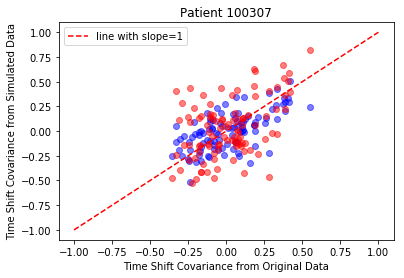

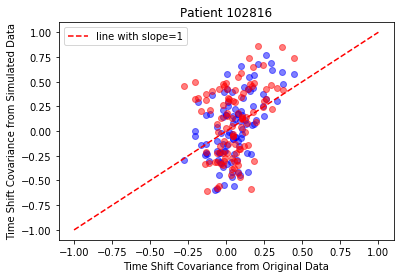

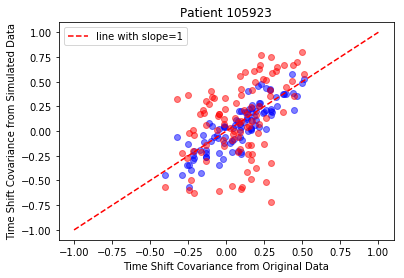

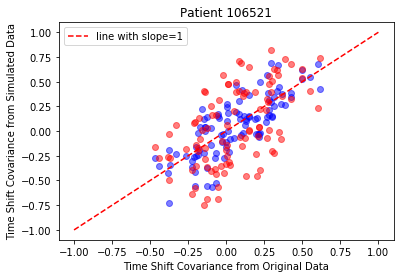

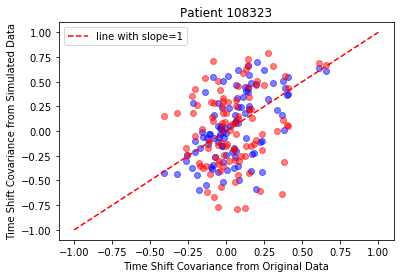

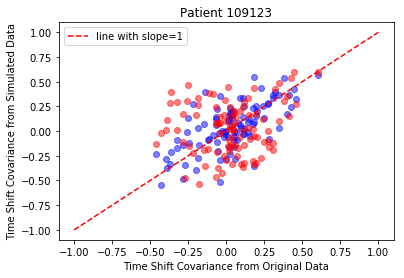

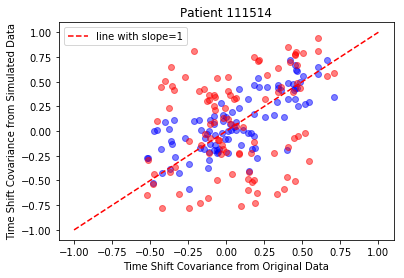

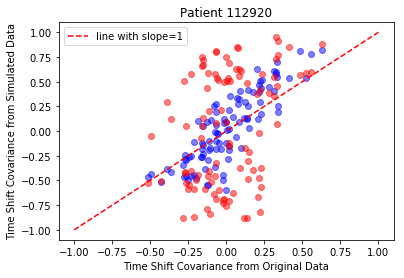

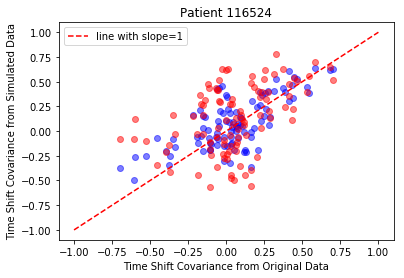

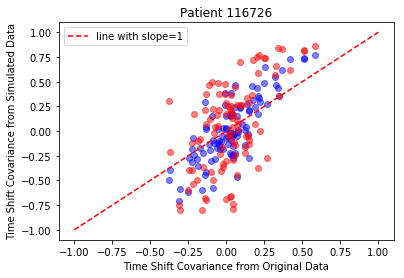

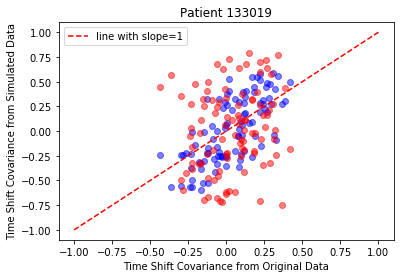

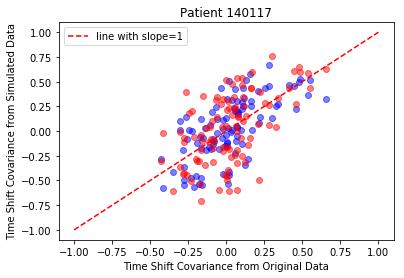

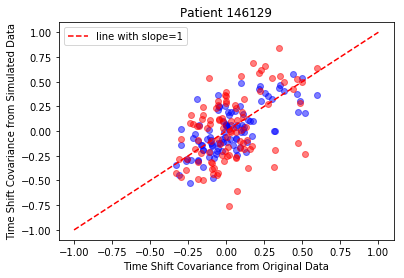

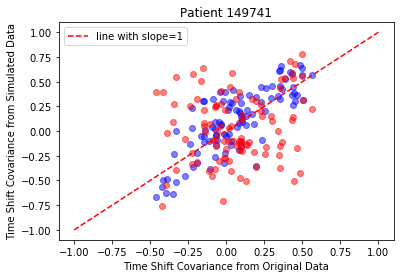

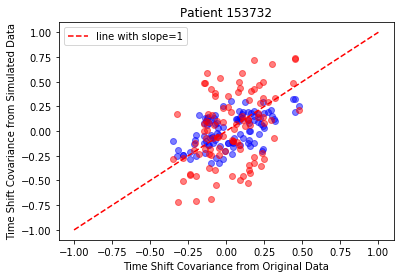

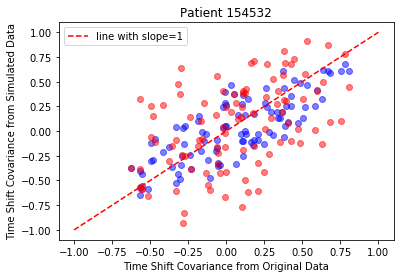

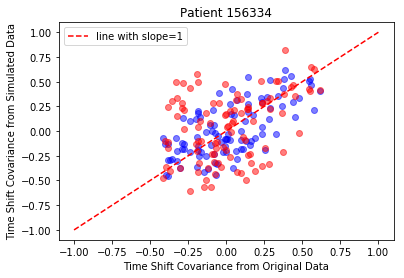

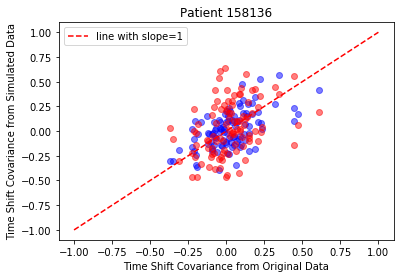

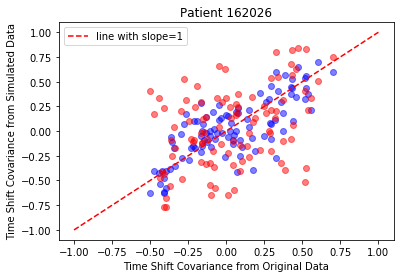

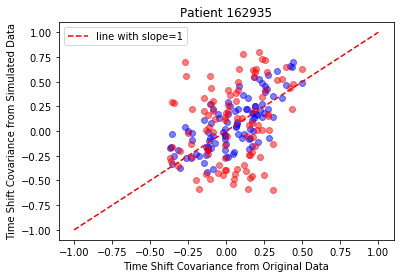

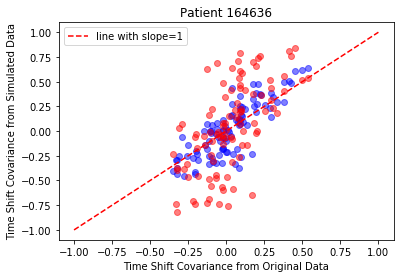

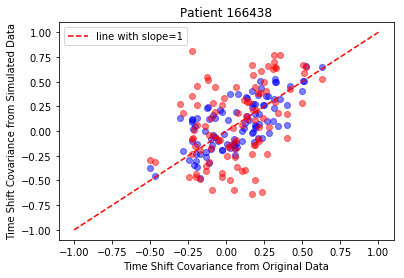

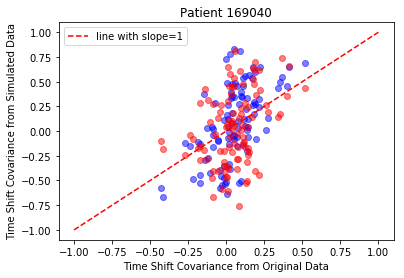

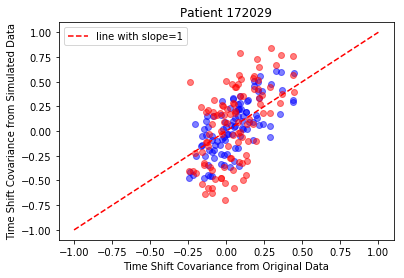

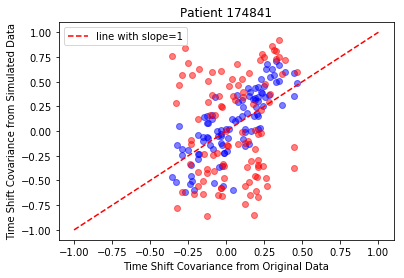

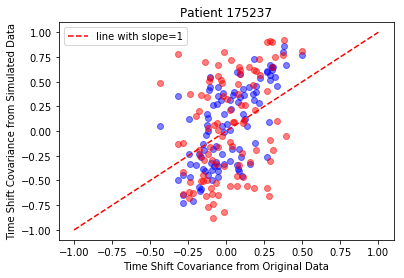

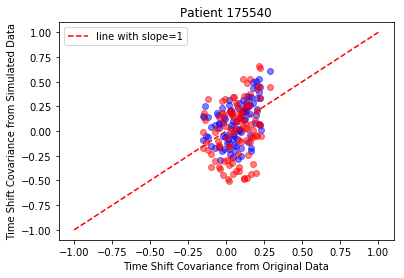

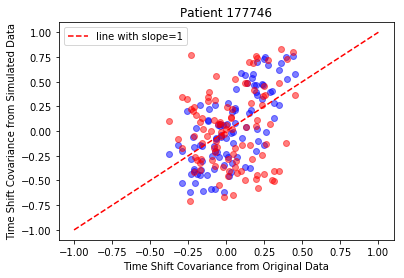

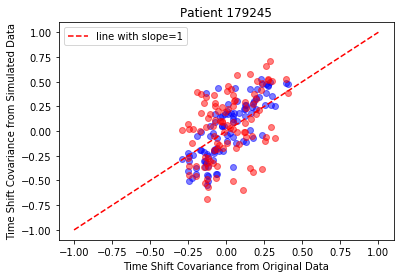

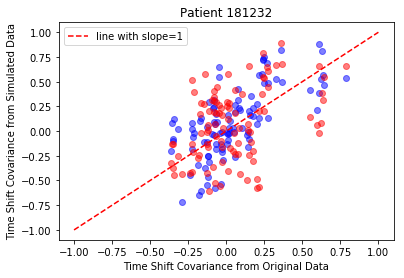

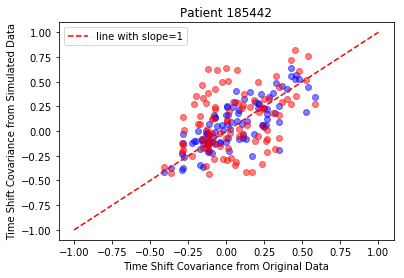

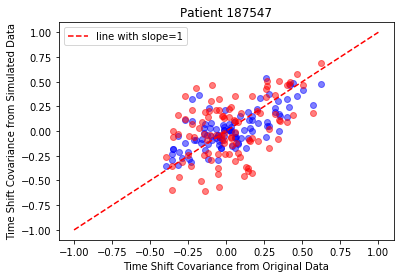

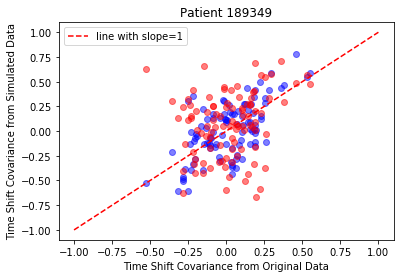

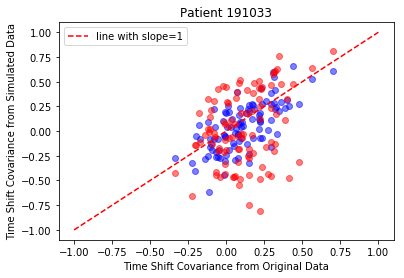

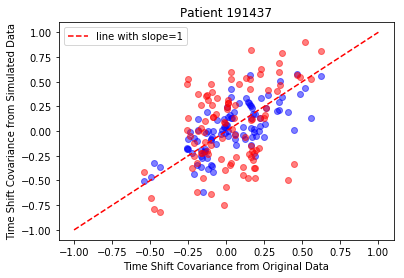

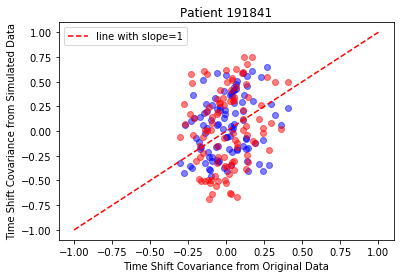

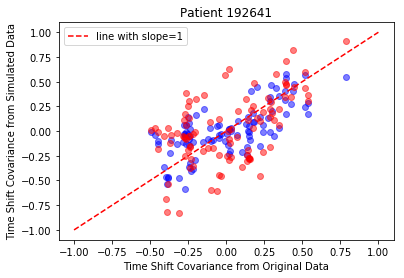

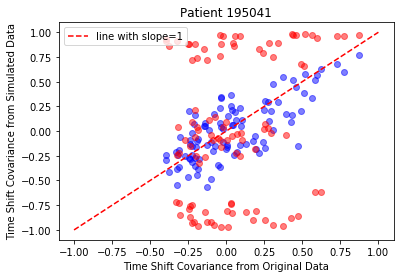

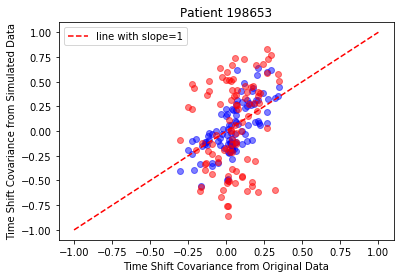

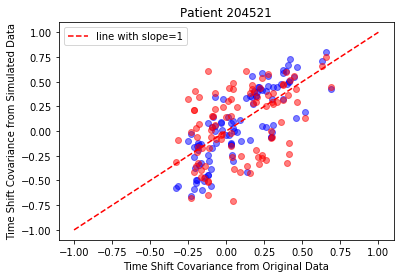

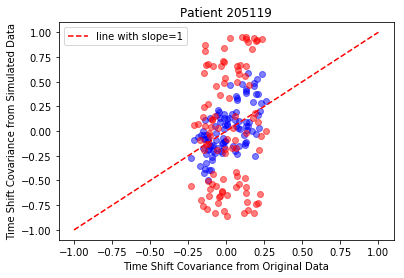

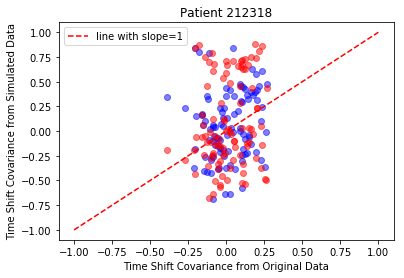

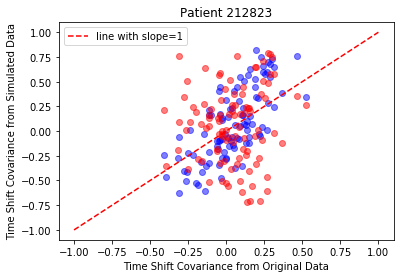

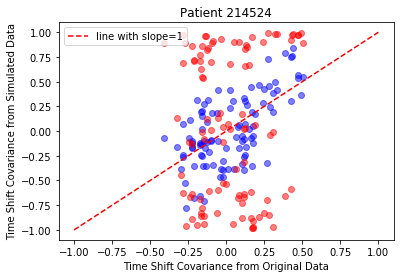

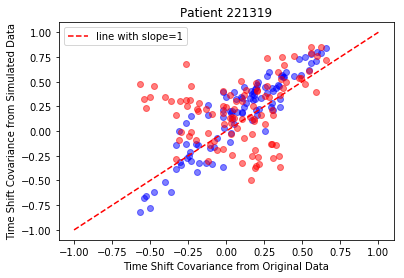

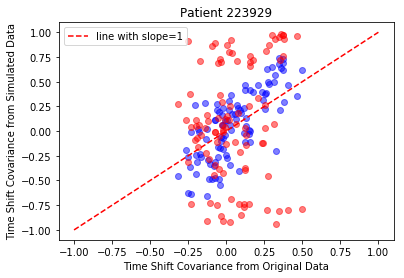

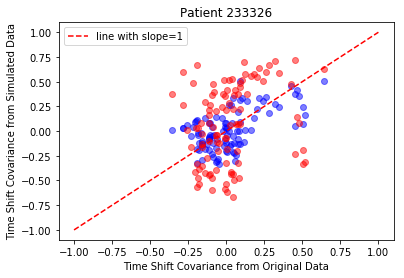

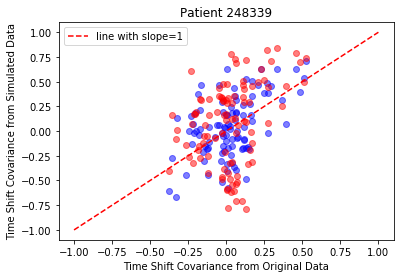

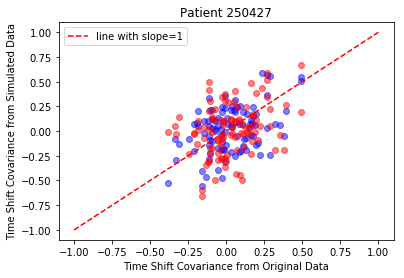

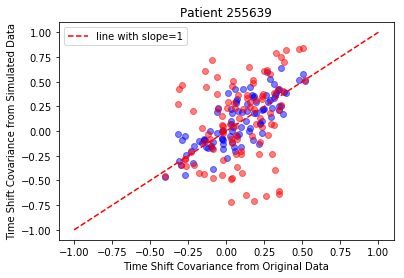

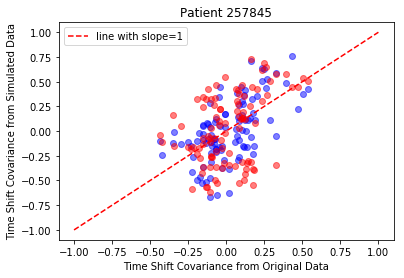

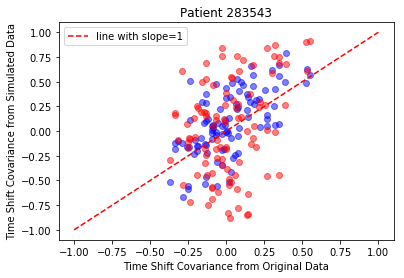

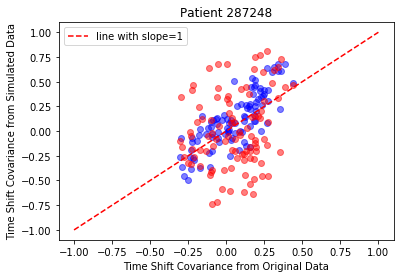

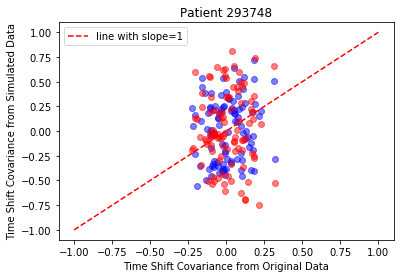

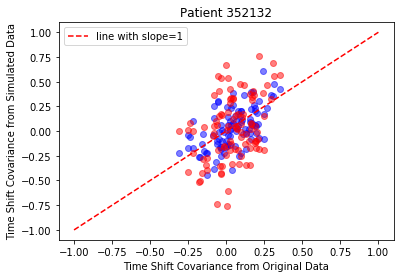

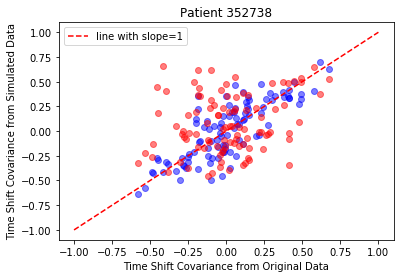

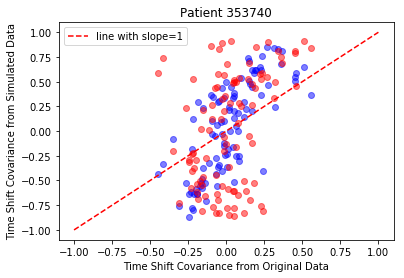

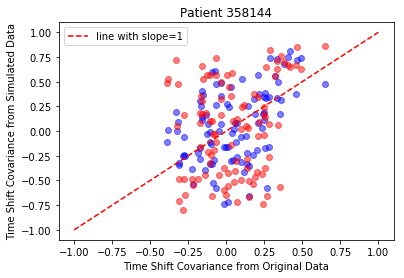

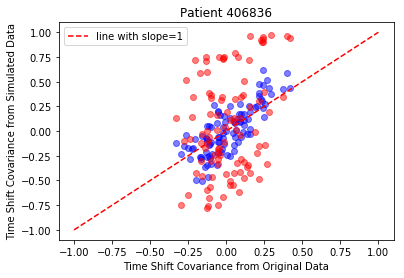

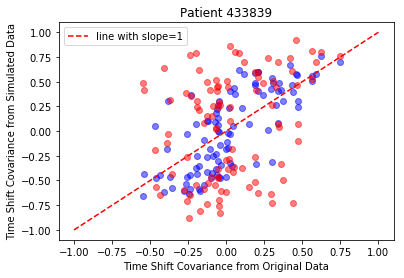

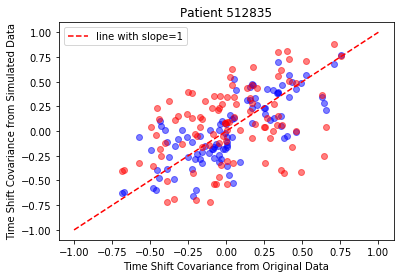

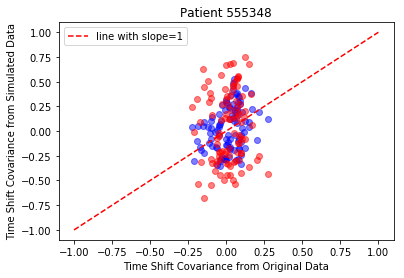

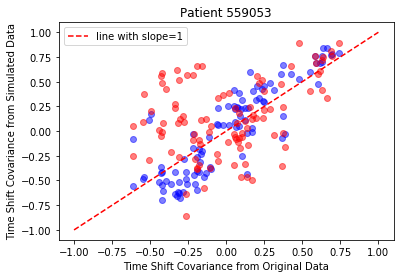

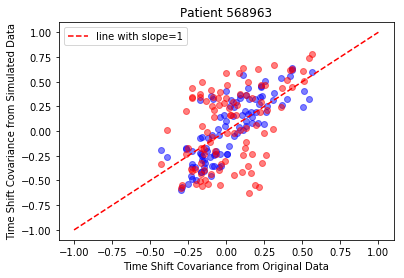

KeyboardInterrupt: 

In [16]:
# allwmatrices is a dictionary with patient identifiers as keys. allwmatrices[key] will return the w matrix 
# for that specific patient
slope_average = 0
pvalue_nonlinear_average = 0
counter = 0
for patient in allwmatrices:
    w = allwmatrices[patient]
    sig = allsigs[patient]
    
    w_transpose =  w.transpose()

    x_original = pca_data_dict[patient].T.copy()

    # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
    simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0)
    simulated_data2 = simulate(pca_components, 1018, w=w_transpose, sigma=sig, rho=0)

    # compute the time shift covariance matrices for the 'original' (transformed PCA MEG timecourse) and simulated data
    tsc_original = time_shift_cov(x_original, shift=10)
    tsc_simulated = time_shift_cov(simulated_data[0], shift=10)
    tsc_simulated2 = time_shift_cov(simulated_data2[0], shift=10)

    line_object = linregress(tsc_original, tsc_simulated)
    plt.title('Patient ' + str(patient))
    plt.xlabel('Time Shift Covariance from Original Data')
    plt.ylabel('Time Shift Covariance from Simulated Data')

#     plt.plot(tsc_original, tsc_simulated, 'ro', alpha=0.5)
    plt.plot(tsc_original, tsc_simulated, 'bo', alpha=0.5)
    plt.plot(tsc_original, tsc_simulated2, 'ro', alpha=0.5)
    
    time_shift_axes = np.arange(-1, 2)
#     plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'r--')

    
    plt.plot([-1, 1], [-1,1], 'r--', label='line with slope=1')
    plt.legend(loc='upper left')

    plt.show()
    plt.close()

In [ ]:
# import matplotlib.backends.backend_pdf
# pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")
# for fig in xrange(1, figure().number): ## will open an empty extra figure :(
#     pdf.savefig( fig )
# pdf.close()
# fig.text(.5, .05, txt, ha='center')
sns.set(style='white', context='notebook', rc={'figure.figsize':(5, 5)})
for patient in allwmatrices:
    w = allwmatrices[patient]
    sig = allsigs[patient]
    bias = allbiases[patient]

    x_original = pca_data_dict[patient].T.copy()

    # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
    simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, bias=bias, power=1, initial=x_original[0])
    w_simulated, sig_simulated, bias_simulated = infer(simulated_data[0], power=1)
    
    f = plt.figure()
    line_object = linregress(w, w_simulated)
    plt.title('Patient ' + str(patient))
    plt.xlabel('W Matrix from Original Data')
    plt.ylabel('W Matrix from Simulated Data')
    plt.xlim([-0.25, 0.25])
    plt.ylim([-0.25, 0.25])
    plt.plot(w, w_simulated, 'ko', alpha=0.5)
    plt.plot([-0.25, 0.25], [-0.25,0.25], 'r--', label='line with slope=1')
    time_shift_axes = np.arange(start=-0.25, stop=0.25, step=0.01)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--', label='linear regression line')
    plt.legend(loc='upper left')
    f.text(0.5, 0, 'P-Value = '+str(line_object.pvalue), ha='center')
    f.savefig('w_matrix_figures/'+patient+'linear.png')
    plt.show()
    plt.close()
#     print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
#     print("--------------------------------------------------------------")

In [ ]:
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")
# for fig in xrange(1, figure().number): ## will open an empty extra figure :(
#     pdf.savefig( fig )
# pdf.close()
# fig.text(.5, .05, txt, ha='center')
sns.set(style='white', context='notebook', rc={'figure.figsize':(6, 6)})
for patient in allwmatrices2:
    w = allwmatrices2[patient]
    sig = allsigs2[patient]
    bias = allbiases2[patient]

    x_original = pca_data_dict2[patient].T.copy()

    # simulate MEG timecourse data using the w, sigma, and bias computed from the inference code
    simulated_data = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, bias=bias, power=3, initial=x_original[0])
    w_simulated, sig_simulated, bias_simulated = infer(simulated_data[0], power=3)
    
    f = plt.figure()
    line_object = linregress(w, w_simulated)
    plt.title('Patient ' + str(patient))
    plt.xlabel('W Matrix from Original Data')
    plt.ylabel('W Matrix from Simulated Data')
    plt.xlim([-0.25, 0.25])
    plt.ylim([-0.25, 0.25])
    plt.plot(w, w_simulated, 'ko', alpha=0.5)
    plt.plot([-0.25, 0.25], [-0.25,0.25], 'r--', label='line with slope=1')
    time_shift_axes = np.arange(start=-0.25, stop=0.25, step=0.01)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--', label='linear regression line')
    plt.legend(loc='upper left')
    f.text(0.5, 0, 'P-Value = '+str(line_object.pvalue), ha='center')
    f.savefig('w_matrix_figures/'+patient+'.png')
    plt.show()
    plt.close()
#     print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
#     print("--------------------------------------------------------------")

In [19]:
#try to quantify pvalue cutoffs for certain time shifts

#run pca on the first 2-3 components of the W matrices
pca_wmatrices = np.array([])
for patient in allwmatrices2:
    if pca_wmatrices.size == 0:
        pca_wmatrices = np.asarray(allwmatrices2[patient])
    else:
        pca_wmatrices = np.concatenate((pca_wmatrices, np.asarray(allwmatrices2[patient])), axis=1)

NameError: name 'allwmatrices2' is not defined

In [ ]:
np.matrix(pca_wmatrices).shape

In [ ]:
pca_w = PCA(n_components=2)
pca_w.fit(np.matrix(pca_wmatrices).T)
transformed_data_w = pca_w.fit_transform(np.matrix(pca_wmatrices).T)

In [ ]:
transformed_data_w

In [ ]:
pca_wmatrices_postprocess = {}
counter = 0
for patient in allwmatrices2:
    print(patient)
    pca_wmatrices_postprocess[patient] = transformed_data_w[counter*10:10*(counter+1), :].T
    counter = counter + 1

In [ ]:
pca_wmatrices_postprocess['100307'].shape

In [ ]:
clustering_prepare_w = []
for patient in pca_wmatrices_postprocess:
    clustering_prepare_w.append(pca_wmatrices_postprocess[patient].flatten())
    

In [ ]:
clustering_prepare_w[0]

In [ ]:
pca_tscmatrices = []
for patient in pca_data_dict:
    pca_tscmatrices.append(time_shift_cov(pca_data_dict[patient].T, shift=40).flatten())

In [ ]:
pca_tsc = PCA(n_components=10)
pca_tsc.fit(np.matrix(pca_tscmatrices))
transformed_data_tsc = pca_tsc.fit_transform(np.matrix(pca_tscmatrices))

In [ ]:
transformed_data_w.shape

In [ ]:
# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_w = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(clustering_prepare_w)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_w = {}
counter = 0
for grouping in clustering_w.labels_:
    if grouping not in cluster_dict_w:
        cluster_dict_w[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_w[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_w:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_w[key]))
    
cluster_number = len(cluster_dict_w.keys())

In [ ]:
# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_tsc = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(transformed_data_tsc)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_tsc = {}
counter = 0
for grouping in clustering_tsc.labels_:
    if grouping not in cluster_dict_tsc:
        cluster_dict_tsc[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_tsc[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_tsc:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_tsc[key]))
    
cluster_number = len(cluster_dict_tsc.keys())

In [ ]:
clustering_w.labels_

In [ ]:
plt.scatter(transformed_data_w[:, 0], transformed_data_w[:, 1], c=clustering_w.labels_, s=50, cmap='Spectral')

In [ ]:
pvalue_avg = []
rvalue_avg = []
for patient in allwmatrices2:
    w = allwmatrices2[patient]
    w_transpose = w.T
    sig = allsigs2[patient]
    bias = allbiases2[patient]
    
    
    simulated_patient = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, bias=bias, power=3, initial=pca_data_dict2[patient].T[0])
    simulated_patient2 = simulate(pca_components, 1018, w=w_transpose, sigma=sig, rho=0, bias=bias, power=3, initial=pca_data_dict2[patient].T[0])
    tsc_original = time_shift_cov(pca_data_dict[patient].T, shift=10)
    tsc_simulated = time_shift_cov(simulated_patient[0], shift=10)
    tsc_simulated2 = time_shift_cov(simulated_patient2[0], shift=10)
    
    line_object = linregress(tsc_original, tsc_simulated)
    plt.title('Patient ' + str(patient))
    plt.xlabel('time_shift_cov original')
    plt.ylabel('time_shift_cov simulated')
    plt.plot(tsc_original, tsc_simulated, 'ro', alpha=0.5)
    plt.plot(tsc_original, tsc_simulated2, 'bo', alpha=0.5)
    
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'r--')
    
    plt.plot([-1, 1], [-1,1], 'g--')
    plt.show()
    plt.close()
    print(line_object.pvalue)
    print(line_object.rvalue)
    pvalue_avg.append(line_object.pvalue)
    rvalue_avg.append(line_object.rvalue)

print('mean p', np.mean(pvalue_avg))
print('std p', np.std(pvalue_avg))
print()
print('mean r', np.mean(rvalue_avg))
print('std r', np.std(rvalue_avg))

In [ ]:
pvalue_avg = []
rvalue_avg = []
for patient in cluster_dict_w[0]:
    w = allwmatrices2[patient]
    sig = allsigs2[patient]
    bias = allbiases2[patient]
    
    
    simulated_patient = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, bias=bias, power=3, initial=pca_data_dict2[patient].T[0])
    tsc_original = time_shift_cov(pca_data_dict[patient].T, shift=20)
    tsc_simulated = time_shift_cov(simulated_patient[0], shift=20)
    
    line_object = linregress(tsc_original, tsc_simulated)
    plt.title('Patient ' + str(patient))
    plt.xlabel('time_shift_cov original')
    plt.ylabel('time_shift_cov simulated')
    plt.plot(tsc_original, tsc_simulated, 'ro', alpha=0.5)
    
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'r--')
    
    plt.plot([-1, 1], [-1,1], 'g--')
    plt.show()
    plt.close()
    print(line_object.pvalue)
    print(line_object.rvalue)
    pvalue_avg.append(line_object.pvalue)
    rvalue_avg.append(line_object.rvalue)

print('mean p', np.mean(pvalue_avg))
print('std p', np.std(pvalue_avg))
print()
print('mean r', np.mean(rvalue_avg))
print('std r', np.std(rvalue_avg))


In [ ]:
pvalue_avg = []
rvalue_avg = []
for patient in cluster_dict_tsc[7]:
    w = allwmatrices2[patient]
    sig = allsigs2[patient]
    bias = allbiases2[patient]
    
    
    simulated_patient = simulate(pca_components, 1018, w=w, sigma=sig, rho=0, bias=bias, power=3)
    tsc_original = time_shift_cov(pca_data_dict[patient].T, shift=40)
    tsc_simulated = time_shift_cov(simulated_patient[0], shift=40)
    
    line_object = linregress(tsc_original, tsc_simulated)
    plt.title('Patient ' + str(patient))
    plt.xlabel('time_shift_cov original')
    plt.ylabel('time_shift_cov simulated')
    plt.plot(tsc_original, tsc_simulated, 'ro', alpha=0.5)
    
    time_shift_axes = np.arange(-1, 2)
    plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'r--')
    
    plt.plot([-1, 1], [-1,1], 'g--')
    plt.show()
    plt.close()
    print(line_object.pvalue)
    print(line_object.rvalue)
    pvalue_avg.append(line_object.pvalue)
    rvalue_avg.append(line_object.rvalue)

print('mean p', np.mean(pvalue_avg))
print('std p', np.std(pvalue_avg))
print()
print('mean r', np.mean(rvalue_avg))
print('std r', np.std(rvalue_avg))

In [ ]:
plt.scatter(transformed_data_w[:, 0], transformed_data_w[:, 1], c=clustering_tsc.labels_, s=50, cmap='Spectral')

In [ ]:
cluster_dict_w

In [ ]:
#try to quantify pvalue cutoffs for certain time shifts

#run pca on the first 2-3 components of the W matrices
pca_tscmatrices = []
for patient in pca_data_dict:
    pca_tscmatrices.append(time_shift_cov(pca_data_dict[patient].T, shift=time_shift).flatten())

In [ ]:
np.matrix(pca_tscmatrices).shape

In [ ]:
pca_tsc = PCA(n_components=2)
pca_tsc.fit(np.matrix(pca_tscmatrices))
transformed_data_tsc = pca_tsc.fit_transform(np.matrix(pca_tscmatrices))

In [ ]:
transformed_data_tsc.shape

In [ ]:
plt.scatter(transformed_data_tsc[:, 0], transformed_data_tsc[:, 1], c=clustering_tsc.labels_, s=50, cmap='Spectral')

In [ ]:
plt.scatter(transformed_data_tsc[:, 0], transformed_data_tsc[:, 1], c=clustering_w.labels_, s=50, cmap='Spectral')

In [ ]:
# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_tsc = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(transformed_data_tsc)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_tsc = {}
counter = 0
for grouping in clustering_tsc.labels_:
    if grouping not in cluster_dict_tsc:
        cluster_dict_tsc[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_tsc[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_tsc:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_tsc[key]))
    
cluster_number = len(cluster_dict_tsc.keys())

In [ ]:
#calculate the average w matrix for each cluster
avg_w_plot = {}
for key in cluster_dict_w:
    avg_w_matrix = np.zeros((pca_components, pca_components))
    count = 0
    for patient in cluster_dict_w[key]:
        avg_w_matrix += allwmatrices2[patient]
        count += 1
    avg_w_plot[key] = avg_w_matrix/count


In [ ]:
for key in avg_w_plot:
    for key2 in avg_w_plot:
        if key2 != key:
            line_object = linregress(avg_w_plot[key], avg_w_plot[key2])
            plt.title('Plot for ' + str(key) + ' and ' + str(key2))
            plt.plot(avg_w_plot[key], avg_w_plot[key2], 'ko', alpha=0.5)
            plt.plot([-1, 1], [-1,1], 'r--')
            time_shift_axes = np.arange(-1, 2)
            plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
            plt.show()
            plt.close()
            plt.show()
            print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
            print("--------------------------------------------------------------")

In [ ]:
for key in avg_w_plot:
    for key2 in avg_w_plot:
        if key2 != key:
            print(key, key2)
            subtract = avg_w_plot[key] - avg_w_plot[key2]
            seaborn.heatmap(subtract)
            plt.show()
            plt.close()

In [ ]:
# calculate the average tsc matrix for each cluster, and plot against each other
avg_tsc_plot = {}
for key in cluster_dict_tsc:
    avg_tsc_matrix = np.zeros((pca_components, pca_components))
    count = 0
    for patient in cluster_dict_tsc[key]:
        avg_tsc_matrix += time_shift_cov(pca_data_dict[patient].T, shift=time_shift)
        count += 1
    avg_tsc_plot[key] = avg_tsc_matrix/count

        


In [ ]:
for key in avg_tsc_plot:
    for key2 in avg_tsc_plot:
        if key2 != key:
            line_object = linregress(avg_tsc_plot[key], avg_tsc_plot[key2])
            plt.title('Plot for ' + str(key) + ' and ' + str(key2))
            plt.plot(avg_tsc_plot[key], avg_tsc_plot[key2], 'ko', alpha=0.5)
            plt.plot([-1, 1], [-1,1], 'r--')
            time_shift_axes = np.arange(-1, 2)
            plt.plot(time_shift_axes, (line_object.slope*time_shift_axes)+line_object.intercept, 'b--')
            plt.show()
            plt.close()
            plt.show()
            print("Slope: ", line_object.slope, "P-Value: ", line_object.pvalue)
            print("--------------------------------------------------------------")

In [ ]:
for key in avg_tsc_plot:
    for key2 in avg_tsc_plot:
        if key2 != key:
            subtract = avg_tsc_plot[key] - avg_tsc_plot[key2]
            seaborn.heatmap(subtract)
            plt.show()
            plt.close()

In [ ]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

def union(lst1, lst2):
    return list(set(lst1) | set(lst2))

In [ ]:
frequency_map = np.zeros((len(cluster_dict_w.keys()), len(cluster_dict_tsc.keys())))
for cluster in cluster_dict_w:
    for cluster2 in cluster_dict_tsc:
        if cluster2 > 2:
            frequency_map[cluster][cluster2-1] = len(intersection(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))/len(union(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))
        else:
            frequency_map[cluster][cluster2] = len(intersection(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))/len(union(cluster_dict_w[cluster], cluster_dict_tsc[cluster2]))
import seaborn
seaborn.heatmap(frequency_map, annot=True)    
plt.show()
plt.close()

In [ ]:
cluster_dict_w[1]

In [ ]:
cluster_dict_tsc[0]

In [ ]:
intersection(cluster_dict_w[1], cluster_dict_tsc[0])

In [ ]:
union(cluster_dict_w[1], cluster_dict_tsc[0])

In [ ]:
# are the same sets of patients in the same cluster groupings across time shift cov and w matrices?
for key in cluster_dict_w:
    print("Cluster", key, ":", cluster_dict_w[key])
print()
for key in cluster_dict_tsc:
    print("Cluster", key, ":", cluster_dict_tsc[key])
    
links = {}
for key in cluster_dict_w:
    for patient in cluster_dict_w[key]:
        for key2 in cluster_dict_tsc:
            for patient2 in cluster_dict_tsc[key2]:
                if patient == patient2:
                    #do something
                    links[patient] = (key, key2)
                    
# for key in cluster_dict_tsc:
#     for patient in cluster_dict_tsc[key]:
#         for key2 in cluster_dict_w:
#             for patient2 in cluster_dict_w[key2]:
#                 if patient == patient2:
#                     #do something
#                     links[patient] = (key, key2)

In [ ]:
links

In [ ]:
frequency_dict = {}
for value in links.values():
    if value not in frequency_dict:
        frequency_dict[value] = 1
    else:
        frequency_dict[value] += 1

for key in frequency_dict:
    if frequency_dict[key] >= 4 :
        print("Cluster Common Count:", key, "=", frequency_dict[key])

In [ ]:
# cluster_mapping_matrix = np.zeros((len(cluster_dict_w.keys()), len(cluster_dict_tsc.keys())))
# for key_w in cluster_dict_w:
#     for key_tsc in cluster_dict_tsc:
#         cluster_mapping_matrix[key_w][key_tsc] = len(intersection(cluster_dict_w[key_w], cluster_dict_tsc[key_tsc]))/len(union(cluster_dict_w[key_w], cluster_dict_tsc[key_tsc]))
        
# import seaborn
# seaborn.heatmap(cluster_mapping_matrix, annot=True)    
# plt.show()
# plt.close()


for num_clusters in range(4, 8):
    kmeans_labels_tsc = cluster.KMeans(n_clusters=num_clusters, random_state=42).fit_predict(flattened_tscmatrix_array)   
    kmeans_labels_w = cluster.KMeans(n_clusters=num_clusters, random_state=42).fit_predict(flattened_wmatrix_array)
    
    cluster_dict_kmeans_w = {}
    counter = 0
    for grouping in kmeans_labels_w:
        if grouping not in cluster_dict_kmeans_w:
            cluster_dict_kmeans_w[grouping] = [dataset_ids[counter]]
        else:
            cluster_dict_kmeans_w[grouping].append(dataset_ids[counter])
        counter = counter + 1

    cluster_dict_kmeans_tsc = {}
    counter = 0
    for grouping in kmeans_labels_tsc:
        if grouping not in cluster_dict_kmeans_tsc:
            cluster_dict_kmeans_tsc[grouping] = [dataset_ids[counter]]
        else:
            cluster_dict_kmeans_tsc[grouping].append(dataset_ids[counter])
        counter = counter + 1
     
    cluster_mapping_matrix = np.zeros((len(cluster_dict_kmeans_w.keys()), len(cluster_dict_kmeans_tsc.keys())))
    for key_w in cluster_dict_kmeans_tsc:
        for key_tsc in cluster_dict_kmeans_tsc:
            cluster_mapping_matrix[key_w][key_tsc] = len(intersection(cluster_dict_kmeans_w[key_w], cluster_dict_kmeans_tsc[key_tsc]))/len(union(cluster_dict_kmeans_w[key_w], cluster_dict_kmeans_tsc[key_tsc]))
    
    import seaborn
    seaborn.heatmap(cluster_mapping_matrix, annot=True)    
    plt.show()
    plt.close()

# Separator

In [ ]:
pca_wmatrix_dictionary = {}
counter = 0
for patient in allwmatrices2:
    pca_wmatrix_dictionary[patient] = transformed_data_w[counter*10:10*(counter+1), :].T
    counter = counter + 1

In [ ]:
pca_wmatrix_dictionary

In [ ]:
# spectral clustering, spectrally cluster the W matrices of all the patients to see if certain patients fall into 
# certain categories. Do for all 88 patients

# prepare a matrix to input into the spectral clustering function, must flatten all the W matrices
def wmatrix_clustering_prepare(allwmatrices):
    flattened_wmatrix_array = []
    unflattened_wmatrix_dict = {}
    counter = 0
    for patient in allwmatrices:
        flattened_matrix = allwmatrices[patient].flatten()
        unflattened_wmatrix_dict[counter] = allwmatrices[patient]
        if len(flattened_wmatrix_array) == 0:
            flattened_wmatrix_array = [flattened_matrix]
        else:
            flattened_wmatrix_array.append(flattened_matrix)
        counter = counter + 1
    return flattened_wmatrix_array, unflattened_wmatrix_dict

flattened_wmatrix_array, unflattened_wmatrix_dict = wmatrix_clustering_prepare(pca_wmatrix_dictionary)

# Cluster the wmatrices using spectral clustering
from sklearn.cluster import SpectralClustering
from scipy import stats
import numpy as np
from itertools import cycle, islice
clustering_w = SpectralClustering(assign_labels="discretize",
             random_state=0).fit(flattened_wmatrix_array)
# clustering = SpectralClustering(assign_labels="kmeans").fit(flattened_wmatrix_array)

cluster_dict_w = {}
counter = 0
for grouping in clustering_w.labels_:
    if grouping not in cluster_dict_w:
        cluster_dict_w[grouping] = [dataset_ids[counter]]
    else:
        cluster_dict_w[grouping].append(dataset_ids[counter])
    counter = counter + 1

for key in cluster_dict_w:
    print("Number of Patients in Cluster", key, ":", len(cluster_dict_w[key]))
    
cluster_number = len(cluster_dict_w.keys())

In [ ]:
import umap
from sklearn.datasets import load_digits

standard_embedding_w = umap.UMAP(random_state=42).fit_transform(np.matrix(flattened_wmatrix_array))
w_embedded = TSNE(n_components=2, random_state=42).fit_transform(flattened_wmatrix_array)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='white', context='notebook', rc={'figure.figsize':(8,8)})
plt.scatter(standard_embedding_w[:, 0], standard_embedding_w[:, 1], c=clustering_w.labels_, s=100, cmap='Spectral');
plt.show()
plt.close()

plt.scatter(w_embedded[:, 0], w_embedded[:, 1], c=clustering_w.labels_, s=100, cmap='Spectral');
plt.show()
plt.close()

In [ ]:
from sklearn.manifold import TSNE
sns.set(style='white', context='notebook', rc={'figure.figsize':(8,8)})

w_embedded = TSNE(n_components=2, random_state=42).fit_transform(flattened_wmatrix_array)

import sklearn.cluster as cluster
kmeans_labels_w = cluster.KMeans(n_clusters=8, random_state=42).fit_predict(flattened_wmatrix_array)

plt.scatter(standard_embedding_w[:, 0], standard_embedding_w[:, 1], c=kmeans_labels_w, s=100, cmap='Spectral');
plt.show()
plt.close()

plt.scatter(w_embedded[:, 0], w_embedded[:, 1], c=kmeans_labels_w, s=100, cmap='Spectral');
plt.show()
plt.close()

In [ ]:
print(kmeans_labels_w)